In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
}))

source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [7]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

### Load guide df

In [9]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

gene     guide1      guide2      alias    subclass class    
1 CD13     CD13-1a     CD13-1b     ANPEP    tss      targeting
2 CD55     CD55-1a     CD55-1b     CD55     tss      targeting
3 CD73     CD73-1a     CD73-1b     NT5E     tss      targeting
4 FUBP1    FUBP1-1a    FUBP1-1b    FUBP1    tss      targeting
5 C15orf40 C15orf40-1a C15orf40-1b C15orf40 tss      targeting
6 MAFF     MAFF-1a     MAFF-1b     MAFF     tss      targeting

## FeaturePlot singlet & doublet

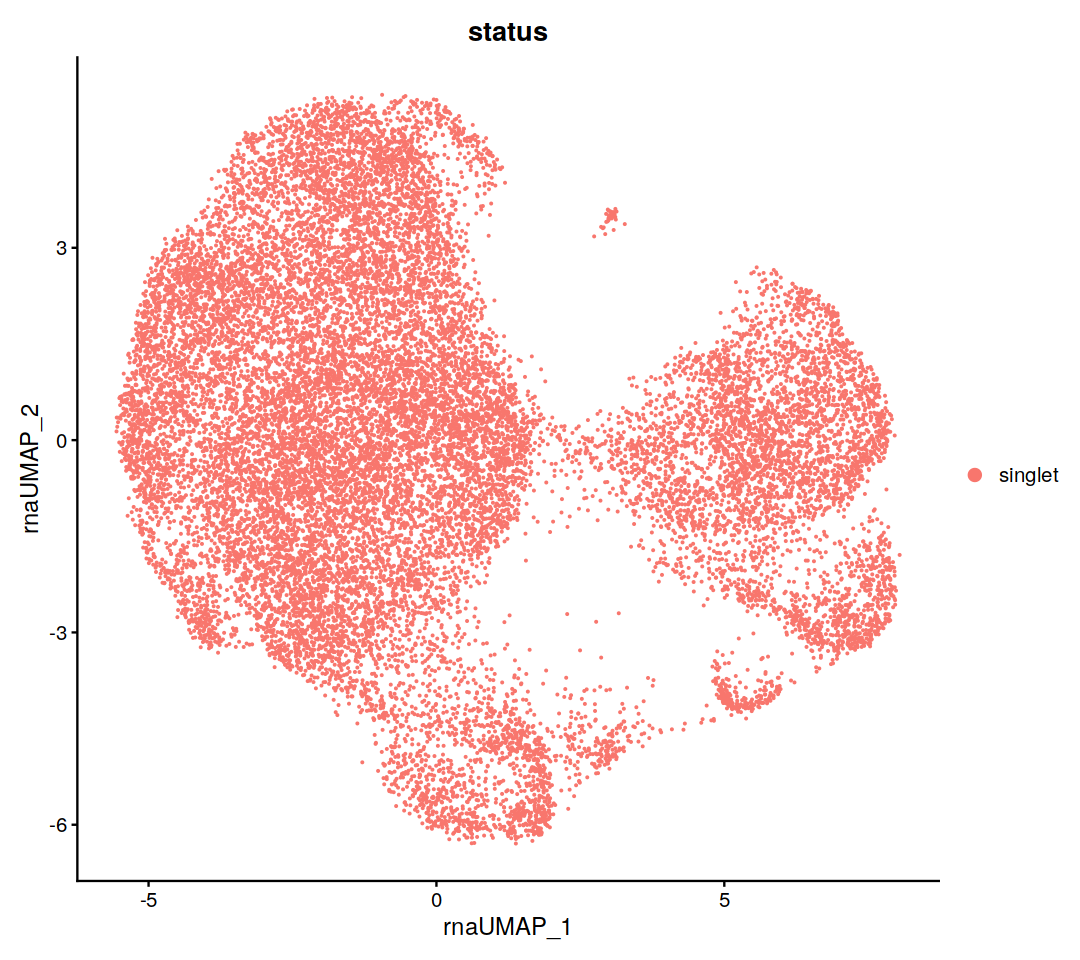

In [10]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries) {
        seurat_lib = seurat_libs[[lib]]
        threshold = df_thresholds[i, lib]
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 947

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [14]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

CD13-1a   1055 
CD55-1a   1905 
CD73-1a   2685 
FUBP1-1a   3333 
C15orf40-1a   4097 
MAFF-1a   4637 
FTH1-1a   5112 
FTH1-2a   7281 
PLIN3-1a   7834 
PLIN3-2a   8251 
TKT-1a   8610 
TKT-2a   9086 
LGALS3-1a   9572 
LGALS3-2a   9976 
CSTB-1a   10446 
CSTB-2a   10879 
CTSB-1a   11341 
CTSB-2a   11718 
KLF6-1a   12083 
KLF6-2a   12464 
DE1-1a   12773 
DE1-2a   13109 
DE2-1a   13109 
DE2-2a   13459 
DE3-1a   13808 
DE3-2a   14113 
DE4-1a   14586 
DE4-2a   14811 
DE5-1a   15093 
DE5-2a   15398 
DE6-1a   15631 
DE6-2a   16140 
DE7-1a   16396 
DE7-2a   16596 
DE8-1a   16836 
DE8-2a   17069 
DE9-1a   17284 
DE9-2a   17284 
DE10-1a   17431 
DE10-2a   17617 
DE11-1a   17817 
DE11-2a   17981 
DE12-1a   18129 
DE12-2a   18265 
DE13-1a   18426 
DE13-2a   18547 
DE14-1a   18701 
DE14-2a   18847 
DE15-1a   18989 
DE15-2a   19151 
DE16-1a   19279 
DE16-2a   19279 
DE17-1a   19399 
DE17-2a   19523 
CD13-1b   19536 
CD55-1b   19553 
CD73-1b   19564 
FUBP1-1b   19574 
C15orf40-1b   19588 
MAFF-1b   19598

# Split by donor, then run DE testing 

In [15]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [16]:
targets = unique(filter(df_guide, class=='targeting')$alias)
df_de = NULL
genes_to_skip = c("CD55", "CSTB", "DE11")
genes_to_skip = c()
donors = sort(unique(seurat_rna$donor))
lfc_threshold = 0.15

for(donor_id in donors){
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)
    
    cat(green("Running Donor#", donor_id, "\n"))
    for(target in targets){
        if(target %in% genes_to_skip){
            cat(red("Skipping", target, "\n"))
            next
        }
        guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
        cat(blue(target,":"), paste(guides_4_target, collapse=","),"\n")
        seurat_dummy <- mark_target_pos_neg(seurat_donor, perturbed_cells_by_guide, guides_4_target, print_counts = T)
        
        markers <- FindMarkers(
            object = seurat_dummy,
            slot = "data",
            ident.1 = 'target_positive',
            ident.2 = 'target_negative',
            test.use = "MAST",
            latent.vars = c("library"),
            logfc.threshold = lfc_threshold,
            verbose = FALSE
        )
        # latent.vars = c('library') 
        if(nrow(markers)==0) {
            cat(Red("No DE genes", target,  "\n"))
        }
        markers$de_gene = rownames(markers)
        markers$target  = target
        markers$donor   = donor_id
        rownames(markers) <- NULL
        df_de = rbind(df_de, markers)
    }
}

Running Donor# 0 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   260 
CD13-1b   350 
Guide+ = 350 ; Guide- = 5297 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>-------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   256 
CD55-1b   346 
Guide+ = 346 ; Guide- = 5301 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [================>---------------------------]  40% with 0 failures

 Completed [=================>---------

NT5E : CD73-1a,CD73-1b 
CD73-1a   223 
CD73-1b   310 
Guide+ = 310 ; Guide- = 5337 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>-------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   191 
FUBP1-1b   259 
Guide+ = 259 ; Guide- = 5388 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>-------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   245 
C15orf40-1b   330 
Guide+ = 330 ; Guide- = 5317 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>-----------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   196 
MAFF-1b   251 
Guide+ = 251 ; Guide- = 5396 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>-----------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   175 
FTH1-2a   958 
FTH1-1b   1004 
FTH1-2b   1004 
Guide+ = 1004 ; Guide- = 4643 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>---------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   235 
PLIN3-2a   471 
PLIN3-1b   556 
PLIN3-2b   629 
Guide+ = 629 ; Guide- = 5018 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>-----

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   185 
TKT-2a   441 
TKT-1b   493 
TKT-2b   589 
Guide+ = 589 ; Guide- = 5058 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [=====================>-----

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   279 
LGALS3-2a   487 
LGALS3-1b   562 
LGALS3-2b   628 
Guide+ = 628 ; Guide- = 5019 



 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   313 
CSTB-2a   581 
CSTB-1b   654 
CSTB-2b   721 
Guide+ = 721 ; Guide- = 4926 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [==========================>

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   311 
CTSB-2a   547 
CTSB-1b   614 
CTSB-2b   665 
Guide+ = 665 ; Guide- = 4982 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>-------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   298 
KLF6-2a   555 
KLF6-1b   633 
KLF6-2b   691 
Guide+ = 691 ; Guide- = 4956 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   269 
DE1-2a   522 
DE1-1b   591 
DE1-2b   689 
Guide+ = 689 ; Guide- = 4958 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   288 
DE2-1b   288 
DE2-2b   383 
Guide+ = 383 ; Guide- = 5264 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>-------------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   276 
DE3-2a   553 
DE3-1b   641 
DE3-2b   719 
Guide+ = 719 ; Guide- = 4928 



 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>--

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   469 
DE4-2a   671 
DE4-1b   696 
DE4-2b   747 
Guide+ = 747 ; Guide- = 4900 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>----------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   294 
DE5-2a   556 
DE5-1b   642 
DE5-2b   710 
Guide+ = 710 ; Guide- = 4937 



 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [=========================>------------------]  58% with 0 failures

 Completed [==========================>-----------------]  61% with 0 failures

 Completed [===========================

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   284 
DE6-2a   815 
DE6-1b   878 
DE6-2b   886 
Guide+ = 886 ; Guide- = 4762 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  56% with 0 failures

 Completed [=========================>-

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   324 
DE7-2a   583 
DE7-1b   669 
DE7-2b   725 
Guide+ = 725 ; Guide- = 4922 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [========================>--

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   310 
DE8-2a   618 
DE8-1b   714 
DE8-2b   826 
Guide+ = 826 ; Guide- = 4821 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>-----------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   328 
DE9-2a   328 
DE9-1b   451 
DE9-2b   451 
Guide+ = 451 ; Guide- = 5196 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>--------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   214 
DE10-2a   443 
DE10-1b   502 
DE10-2b   569 
Guide+ = 569 ; Guide- = 5078 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   310 
DE11-2a   574 
DE11-1b   641 
DE11-2b   706 
Guide+ = 706 ; Guide- = 4941 



 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>-

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   241 
DE12-2a   468 
DE12-1b   531 
DE12-2b   609 
Guide+ = 609 ; Guide- = 5038 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>-----------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   238 
DE13-2a   428 
DE13-1b   437 
DE13-2b   507 
Guide+ = 507 ; Guide- = 5140 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>-------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   308 
DE14-2a   548 
DE14-1b   612 
DE14-2b   666 
Guide+ = 666 ; Guide- = 4981 



 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [===========================

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   269 
DE15-2a   529 
DE15-1b   612 
DE15-2b   712 
Guide+ = 712 ; Guide- = 4935 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   219 
DE16-2a   219 
DE16-1b   312 
DE16-2b   553 
Guide+ = 553 ; Guide- = 5094 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>-------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   259 
DE17-2a   481 
DE17-1b   561 
DE17-2b   642 
Guide+ = 642 ; Guide- = 5005 



 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>--

Running Donor# 1 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   227 
CD13-1b   293 
Guide+ = 293 ; Guide- = 4347 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   210 
CD55-1b   282 
Guide+ = 282 ; Guide- = 4358 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

NT5E : CD73-1a,CD73-1b 
CD73-1a   195 
CD73-1b   262 
Guide+ = 262 ; Guide- = 4378 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>--

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   187 
FUBP1-1b   237 
Guide+ = 237 ; Guide- = 4403 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>-------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   209 
C15orf40-1b   275 
Guide+ = 275 ; Guide- = 4365 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>--------------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   180 
MAFF-1b   224 
Guide+ = 224 ; Guide- = 4416 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   165 
FTH1-2a   818 
FTH1-1b   865 
FTH1-2b   865 
Guide+ = 865 ; Guide- = 3775 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>-------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   244 
PLIN3-2a   434 
PLIN3-1b   494 
PLIN3-2b   544 
Guide+ = 544 ; Guide- = 4096 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>-------------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   182 
TKT-2a   376 
TKT-1b   425 
TKT-2b   488 
Guide+ = 488 ; Guide- = 4152 



 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>---------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   220 
LGALS3-2a   415 
LGALS3-1b   464 
LGALS3-2b   522 
Guide+ = 522 ; Guide- = 4118 



 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [=============================>--------------]  69% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [===================================>--------]  81% with 0 failures

 Completed [=====================================>------]  88% with 0 failures

 Completed [========================================>---]  94% with 0 failures

 Completed [===========================

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   217 
CSTB-2a   453 
CSTB-1b   517 
CSTB-2b   573 
Guide+ = 573 ; Guide- = 4067 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>---------------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   237 
CTSB-2a   445 
CTSB-1b   506 
CTSB-2b   558 
Guide+ = 558 ; Guide- = 4082 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>----------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   209 
KLF6-2a   431 
KLF6-1b   497 
KLF6-2b   557 
Guide+ = 557 ; Guide- = 4083 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [================>----------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   200 
DE1-2a   421 
DE1-1b   472 
DE1-2b   537 
Guide+ = 537 ; Guide- = 4103 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>----------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   215 
DE2-1b   215 
DE2-2b   292 
Guide+ = 292 ; Guide- = 4348 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   253 
DE3-2a   463 
DE3-1b   525 
DE3-2b   590 
Guide+ = 590 ; Guide- = 4050 



 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [==========================>-----------------]  61% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [=============================>--------------]  68% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [===========================

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   375 
DE4-2a   541 
DE4-1b   560 
DE4-2b   618 
Guide+ = 618 ; Guide- = 4022 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>------------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   262 
DE5-2a   493 
DE5-1b   550 
DE5-2b   610 
Guide+ = 610 ; Guide- = 4030 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>-----------

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   235 
DE6-2a   645 
DE6-1b   710 
DE6-2b   712 
Guide+ = 712 ; Guide- = 3929 



 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  40% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>-------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   247 
DE7-2a   450 
DE7-1b   527 
DE7-2b   589 
Guide+ = 589 ; Guide- = 4051 



 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>-------------------]  58% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [============================>---------------]  65% with 0 failures

 Completed [=============================>--------------]  69% with 0 failures

 Completed [===============================>------------]  73% with 0 failures

 Completed [=================================>----------]  77% with 0 failures

 Completed [===========================

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   249 
DE8-2a   498 
DE8-1b   578 
DE8-2b   647 
Guide+ = 647 ; Guide- = 3993 



 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [==========================>

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   225 
DE9-2a   225 
DE9-1b   316 
DE9-2b   316 
Guide+ = 316 ; Guide- = 4324 



 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>-------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   181 
DE10-2a   353 
DE10-1b   397 
DE10-2b   463 
Guide+ = 463 ; Guide- = 4177 



 Completed [===============>----------------------------]  36% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [=============================>--------------]  68% with 0 failures

 Completed [===============================>------------]  73% with 0 failures

 Completed [=================================>----------]  77% with 0 failures

 Completed [===================================>--------]  82% with 0 failures

 Completed [=====================================>------]  86% with 0 failures

 Completed [===========================

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   213 
DE11-2a   416 
DE11-1b   481 
DE11-2b   541 
Guide+ = 541 ; Guide- = 4099 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   229 
DE12-2a   426 
DE12-1b   479 
DE12-2b   560 
Guide+ = 560 ; Guide- = 4080 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>----------------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   199 
DE13-2a   356 
DE13-1b   362 
DE13-2b   416 
Guide+ = 416 ; Guide- = 4224 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   251 
DE14-2a   467 
DE14-1b   532 
DE14-2b   588 
Guide+ = 588 ; Guide- = 4052 



 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>----

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   197 
DE15-2a   446 
DE15-1b   505 
DE15-2b   580 
Guide+ = 580 ; Guide- = 4060 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   169 
DE16-2a   169 
DE16-1b   236 
DE16-2b   453 
Guide+ = 453 ; Guide- = 4187 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   211 
DE17-2a   400 
DE17-1b   453 
DE17-2b   514 
Guide+ = 514 ; Guide- = 4126 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>-----------------

Running Donor# 2 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   330 
CD13-1b   434 
Guide+ = 434 ; Guide- = 5803 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   273 
CD55-1b   371 
Guide+ = 371 ; Guide- = 5866 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>------------

NT5E : CD73-1a,CD73-1b 
CD73-1a   257 
CD73-1b   346 
Guide+ = 346 ; Guide- = 5891 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>--------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   260 
FUBP1-1b   331 
Guide+ = 331 ; Guide- = 5906 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   307 
C15orf40-1b   393 
Guide+ = 393 ; Guide- = 5844 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>----------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   233 
MAFF-1b   327 
Guide+ = 327 ; Guide- = 5910 



 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>---------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   219 
FTH1-2a   1151 
FTH1-1b   1211 
FTH1-2b   1211 
Guide+ = 1211 ; Guide- = 5026 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>-----------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   299 
PLIN3-2a   521 
PLIN3-1b   601 
PLIN3-2b   683 
Guide+ = 683 ; Guide- = 5554 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>--------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   242 
TKT-2a   539 
TKT-1b   618 
TKT-2b   705 
Guide+ = 705 ; Guide- = 5532 



 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>--------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   324 
LGALS3-2a   576 
LGALS3-1b   655 
LGALS3-2b   728 
Guide+ = 728 ; Guide- = 5509 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [========================>--

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   304 
CSTB-2a   596 
CSTB-1b   683 
CSTB-2b   772 
Guide+ = 772 ; Guide- = 5465 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   374 
CTSB-2a   635 
CTSB-1b   710 
CTSB-2b   772 
Guide+ = 772 ; Guide- = 5465 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [================>----------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   291 
KLF6-2a   592 
KLF6-1b   667 
KLF6-2b   739 
Guide+ = 739 ; Guide- = 5498 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>--------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   288 
DE1-2a   567 
DE1-1b   644 
DE1-2b   751 
Guide+ = 751 ; Guide- = 5486 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   325 
DE2-1b   325 
DE2-2b   426 
Guide+ = 426 ; Guide- = 5811 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>------------------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   356 
DE3-2a   650 
DE3-1b   742 
DE3-2b   847 
Guide+ = 847 ; Guide- = 5390 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>----

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   545 
DE4-2a   790 
DE4-1b   812 
DE4-2b   875 
Guide+ = 875 ; Guide- = 5362 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   335 
DE5-2a   670 
DE5-1b   764 
DE5-2b   853 
Guide+ = 853 ; Guide- = 5384 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [=========================>-

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   310 
DE6-2a   859 
DE6-1b   935 
DE6-2b   936 
Guide+ = 936 ; Guide- = 5302 



 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=======================>---

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   374 
DE7-2a   615 
DE7-1b   708 
DE7-2b   780 
Guide+ = 780 ; Guide- = 5457 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>-----

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   329 
DE8-2a   695 
DE8-1b   814 
DE8-2b   912 
Guide+ = 912 ; Guide- = 5325 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   340 
DE9-2a   340 
DE9-1b   455 
DE9-2b   455 
Guide+ = 455 ; Guide- = 5782 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   260 
DE10-2a   504 
DE10-1b   575 
DE10-2b   667 
Guide+ = 667 ; Guide- = 5570 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>------------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   338 
DE11-2a   602 
DE11-1b   676 
DE11-2b   752 
Guide+ = 752 ; Guide- = 5485 



 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [========================>-------------------]  58% with 0 failures

 Completed [==========================>-----------------]  61% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [===========================

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   306 
DE12-2a   545 
DE12-1b   622 
DE12-2b   701 
Guide+ = 701 ; Guide- = 5536 



 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>-

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   292 
DE13-2a   501 
DE13-1b   507 
DE13-2b   566 
Guide+ = 566 ; Guide- = 5671 



 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>----

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   325 
DE14-2a   575 
DE14-1b   667 
DE14-2b   732 
Guide+ = 732 ; Guide- = 5505 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>---------------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   268 
DE15-2a   594 
DE15-1b   655 
DE15-2b   750 
Guide+ = 750 ; Guide- = 5487 



 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>-----------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   274 
DE16-2a   274 
DE16-1b   398 
DE16-2b   656 
Guide+ = 656 ; Guide- = 5581 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>---------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   276 
DE17-2a   538 
DE17-1b   607 
DE17-2b   692 
Guide+ = 692 ; Guide- = 5545 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>------------

Running Donor# 3 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   238 
CD13-1b   313 
Guide+ = 313 ; Guide- = 4526 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   208 
CD55-1b   299 
Guide+ = 299 ; Guide- = 4540 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>-------------------

NT5E : CD73-1a,CD73-1b 
CD73-1a   214 
CD73-1b   284 
Guide+ = 284 ; Guide- = 4555 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   172 
FUBP1-1b   233 
Guide+ = 233 ; Guide- = 4606 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>-------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   229 
C15orf40-1b   289 
Guide+ = 289 ; Guide- = 4550 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   188 
MAFF-1b   241 
Guide+ = 241 ; Guide- = 4598 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   159 
FTH1-2a   867 
FTH1-1b   917 
FTH1-2b   917 
Guide+ = 917 ; Guide- = 3922 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [================>---------------------------]  40% with 0 failures

 Completed [=================>---------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   225 
PLIN3-2a   385 
PLIN3-1b   439 
PLIN3-2b   501 
Guide+ = 501 ; Guide- = 4338 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>-----------------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   156 
TKT-2a   339 
TKT-1b   399 
TKT-2b   473 
Guide+ = 473 ; Guide- = 4366 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   236 
LGALS3-2a   440 
LGALS3-1b   510 
LGALS3-2b   573 
Guide+ = 573 ; Guide- = 4266 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>------------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   240 
CSTB-2a   447 
CSTB-1b   527 
CSTB-2b   576 
Guide+ = 576 ; Guide- = 4263 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  40% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  47% with 0 failures

 Completed [====================>------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   262 
CTSB-2a   482 
CTSB-1b   545 
CTSB-2b   587 
Guide+ = 587 ; Guide- = 4252 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   237 
KLF6-2a   454 
KLF6-1b   513 
KLF6-2b   563 
Guide+ = 563 ; Guide- = 4276 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>---------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   211 
DE1-2a   464 
DE1-1b   524 
DE1-2b   588 
Guide+ = 588 ; Guide- = 4251 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   248 
DE2-1b   248 
DE2-2b   319 
Guide+ = 319 ; Guide- = 4520 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  40% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  47% with 0 failures

 Completed [====================>------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   253 
DE3-2a   468 
DE3-1b   529 
DE3-2b   598 
Guide+ = 598 ; Guide- = 4241 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>------------------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   436 
DE4-2a   608 
DE4-1b   620 
DE4-2b   657 
Guide+ = 657 ; Guide- = 4182 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==========>----------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   272 
DE5-2a   537 
DE5-1b   602 
DE5-2b   668 
Guide+ = 668 ; Guide- = 4171 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [========================>--

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   224 
DE6-2a   641 
DE6-1b   710 
DE6-2b   713 
Guide+ = 713 ; Guide- = 4127 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>-------------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   252 
DE7-2a   448 
DE7-1b   496 
DE7-2b   554 
Guide+ = 554 ; Guide- = 4285 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>-----------------

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   259 
DE8-2a   528 
DE8-1b   608 
DE8-2b   690 
Guide+ = 690 ; Guide- = 4149 



 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [=========================>-

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   229 
DE9-2a   229 
DE9-1b   320 
DE9-2b   320 
Guide+ = 320 ; Guide- = 4519 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>--------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   219 
DE10-2a   412 
DE10-1b   471 
DE10-2b   527 
Guide+ = 527 ; Guide- = 4312 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   249 
DE11-2a   431 
DE11-1b   485 
DE11-2b   555 
Guide+ = 555 ; Guide- = 4284 



 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [=============================>--------------]  68% with 0 failures

 Completed [===============================>------------]  72% with 0 failures

 Completed [===========================

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   227 
DE12-2a   433 
DE12-1b   493 
DE12-2b   560 
Guide+ = 560 ; Guide- = 4279 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   206 
DE13-2a   367 
DE13-1b   371 
DE13-2b   423 
Guide+ = 423 ; Guide- = 4416 



 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>-------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   246 
DE14-2a   446 
DE14-1b   520 
DE14-2b   568 
Guide+ = 568 ; Guide- = 4271 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>-------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   211 
DE15-2a   489 
DE15-1b   548 
DE15-2b   620 
Guide+ = 620 ; Guide- = 4219 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   188 
DE16-2a   188 
DE16-1b   263 
DE16-2b   490 
Guide+ = 490 ; Guide- = 4349 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>-------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   238 
DE17-2a   429 
DE17-1b   487 
DE17-2b   551 
Guide+ = 551 ; Guide- = 4288 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

Write hits to file

In [17]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
lfc = gsub("\\.", "_", lfc_threshold)
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_donor_LFC_", lfc, "_UNFILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
df_de = filter(df_de, !(de_gene  %in% funky_de_genes))

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_donor_LFC_", lfc, "_FILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)




Attaching package: 'huxtable'


The following object is masked from 'package:ggpubr':

    font


The following objects are masked from 'package:crayon':

    bold, italic


The following objects are masked from 'package:Hmisc':

    contents, label, label<-


The following object is masked from 'package:scales':

    number_format


The following object is masked from 'package:ggplot2':

    theme_grey


The following object is masked from 'package:dplyr':

    add_rownames


The following object is masked from 'package:AnnotationDbi':

    contents


The following object is masked from 'package:Biobase':

    contents


The following objects are masked from 'package:GenomicRanges':

    width, width<-


The following objects are masked from 'package:IRanges':

    width, width<-


The following object is masked from 'package:S4Vectors':

    width


The following objects are masked from 'package:BiocGenerics':

    width, width<-




0 
1 


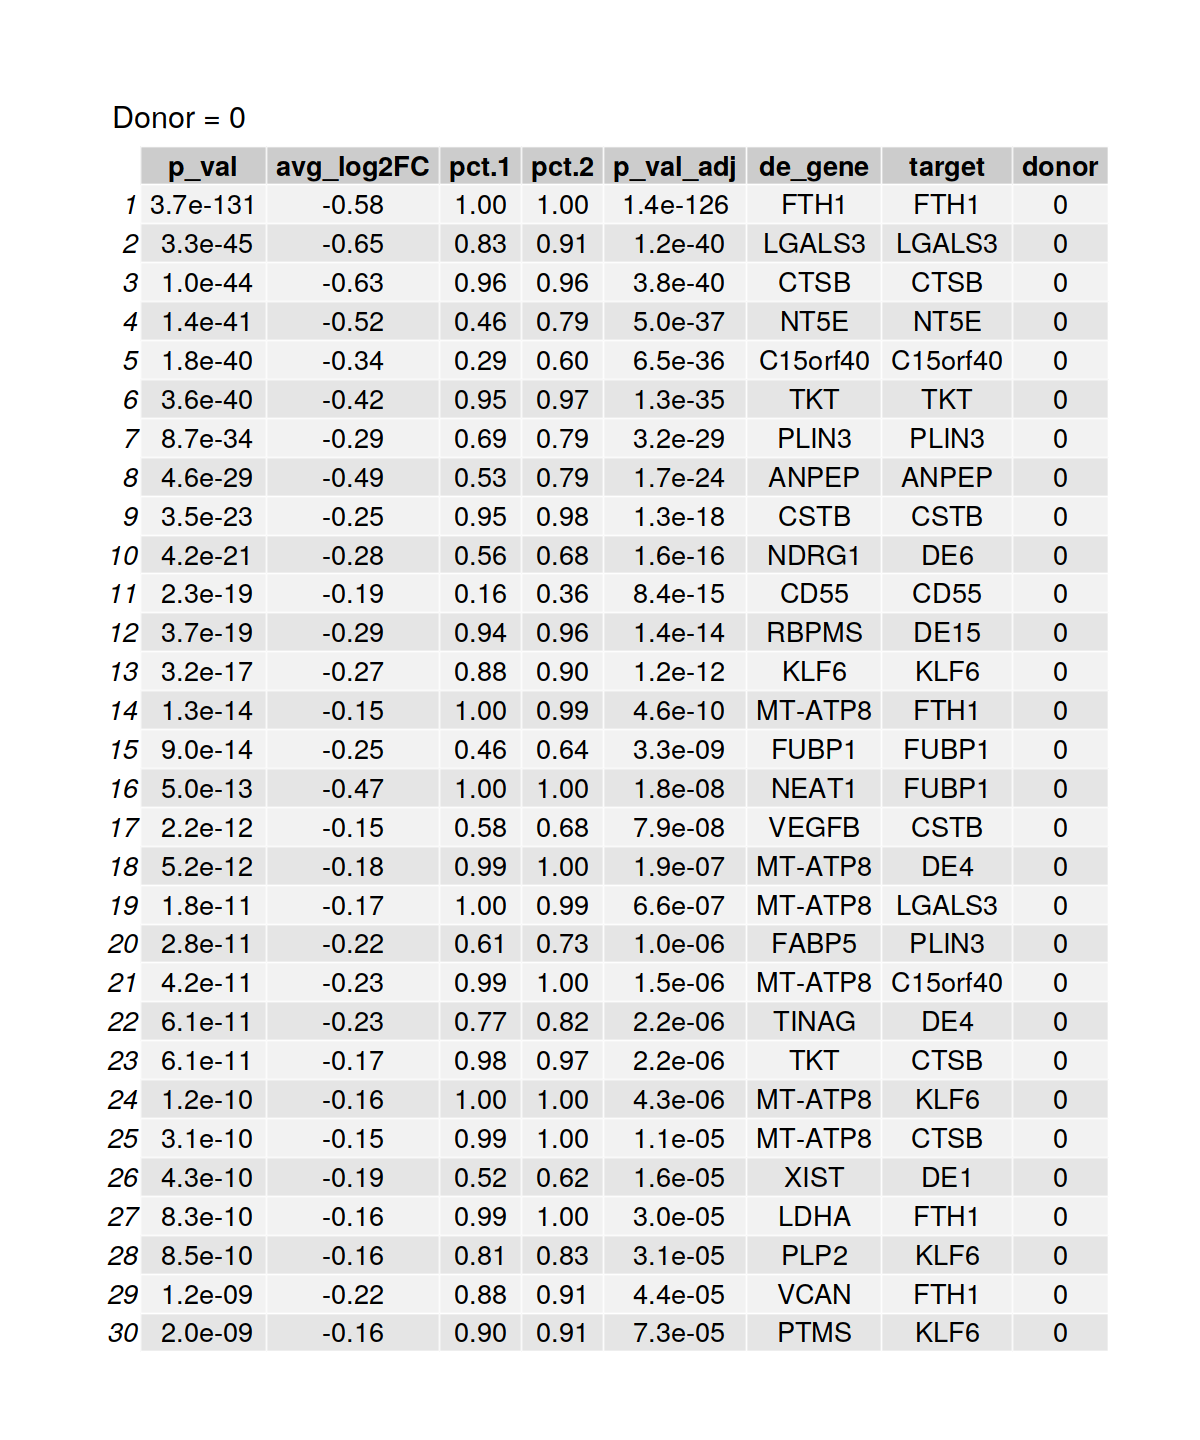

2 


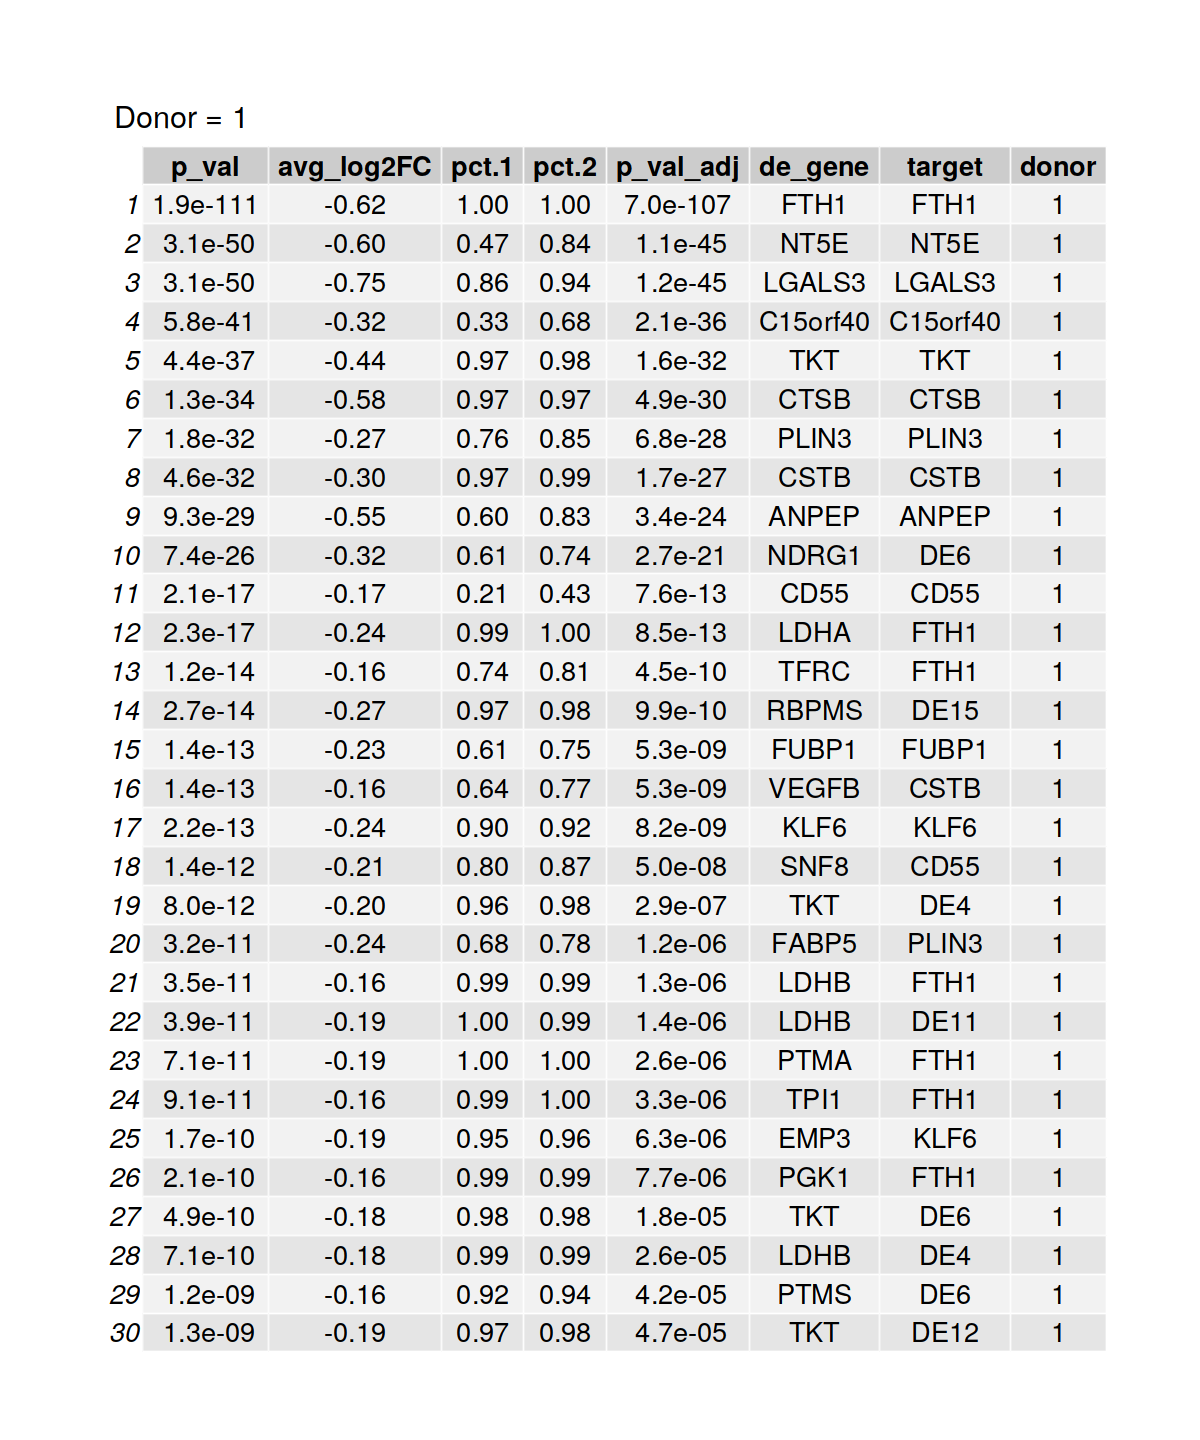

3 


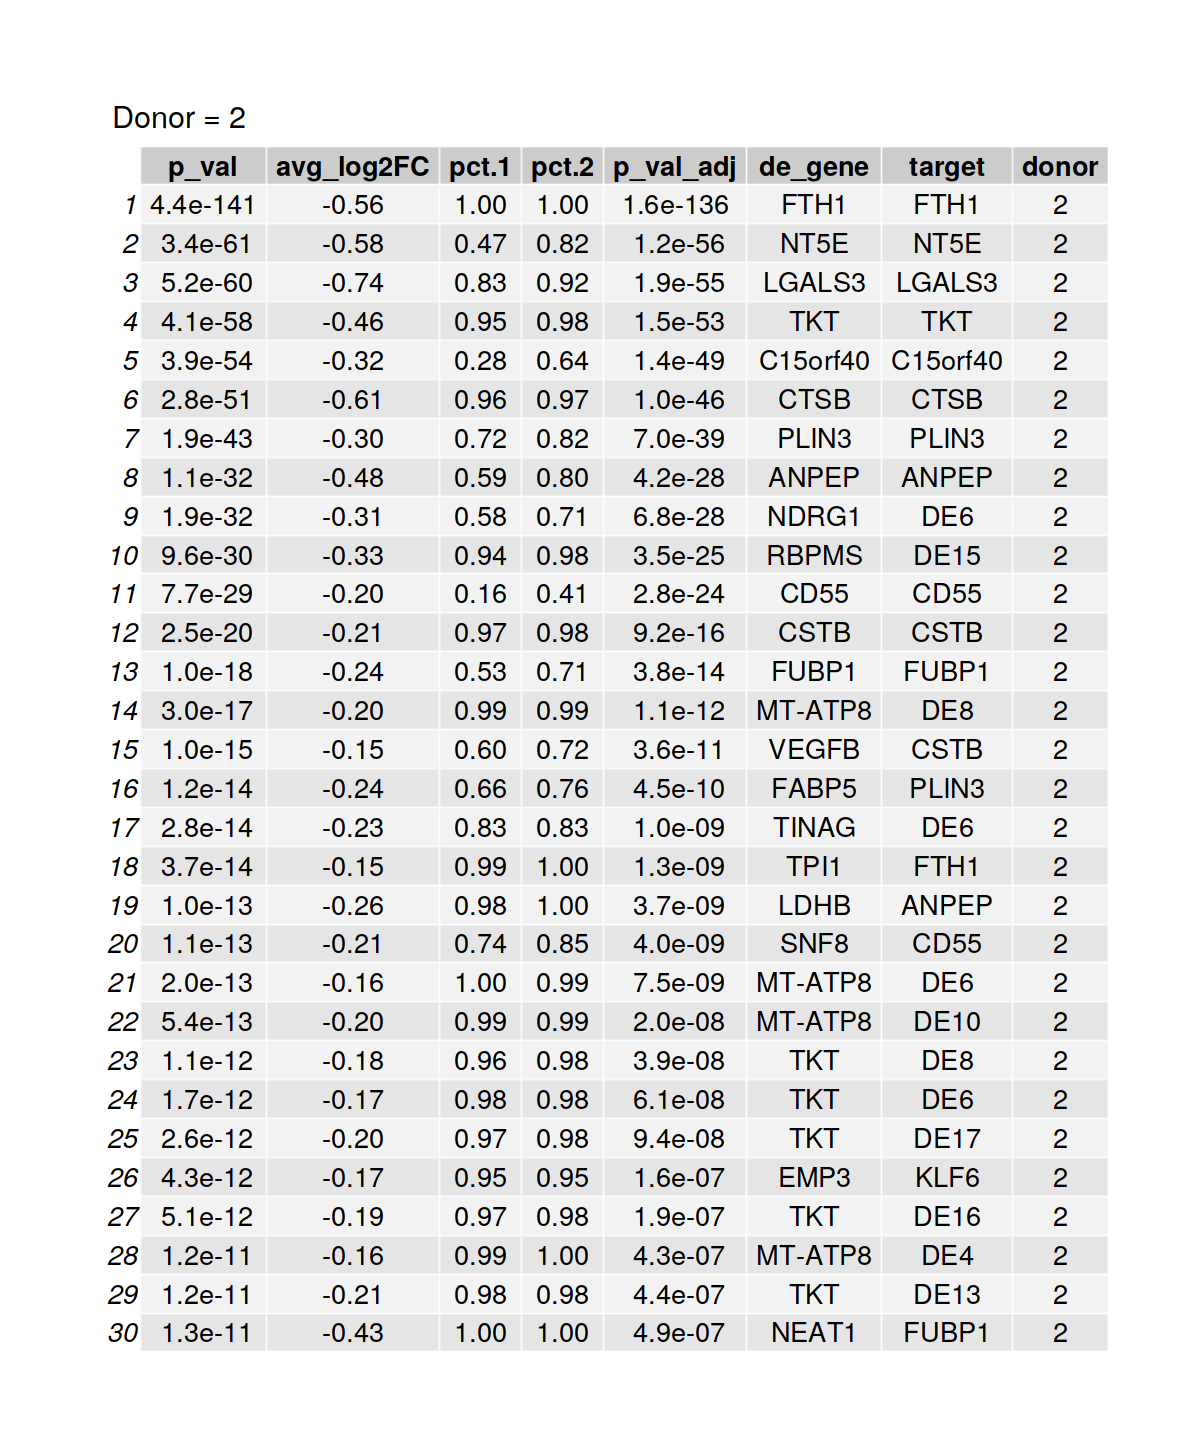

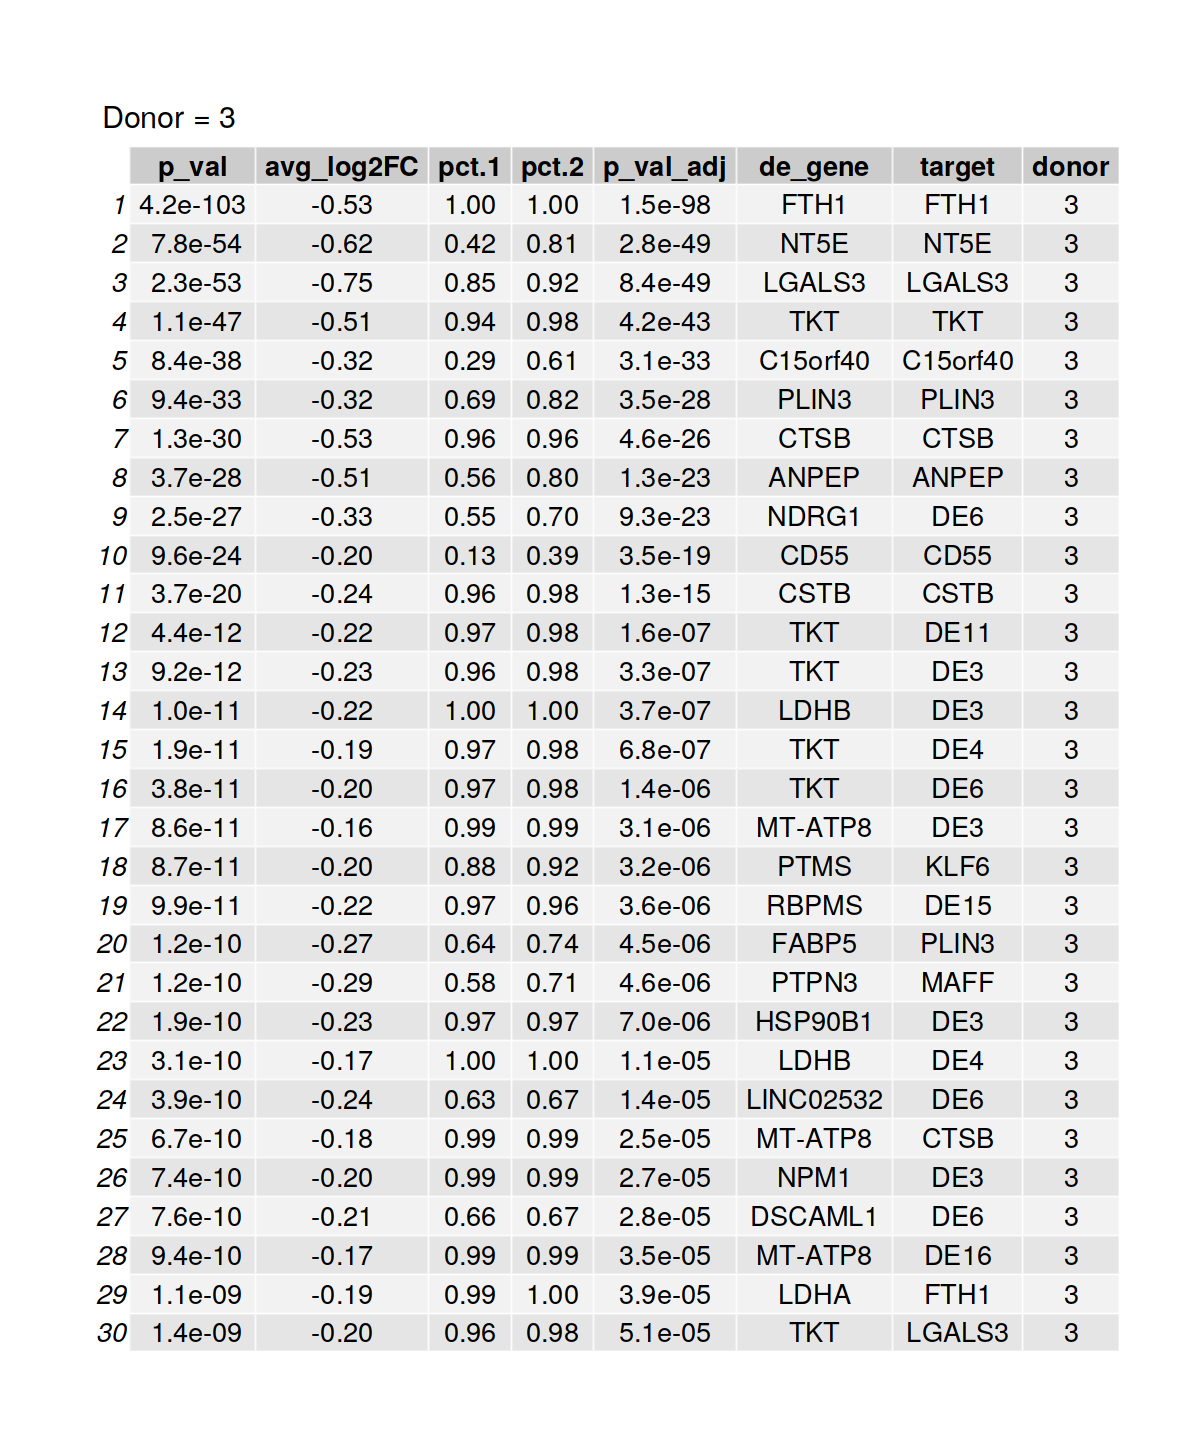

In [18]:
library(huxtable)
options(repr.plot.width = 10, repr.plot.height = 12)
for(donor_id in donors) {
    df_dummy = df_de %>% filter(avg_log2FC < 0 & p_val_adj < 0.05) %>% filter(donor == donor_id) %>% arrange(p_val_adj) %>% head(30)
    cat(green(donor_id, "\n"))
    title <- paste0("Donor = ", donor_id)
    tb <- ggtexttable(df_dummy, theme= ttheme(base_size = 16)) %>% tab_add_title(text = title, face = "plain", size = 18)
    print(tb)
}


## TSS controls

[1] "ANPEP"
Guide+ = 350 ; Guide- = 5297 
[1] "CD55"
Guide+ = 346 ; Guide- = 5301 
[1] "NT5E"
Guide+ = 310 ; Guide- = 5337 
[1] "FUBP1"
Guide+ = 259 ; Guide- = 5388 
[1] "C15orf40"
Guide+ = 330 ; Guide- = 5317 
[1] "MAFF"
Guide+ = 251 ; Guide- = 5396 
[1] "ANPEP"
Guide+ = 293 ; Guide- = 4347 
[1] "CD55"
Guide+ = 282 ; Guide- = 4358 
[1] "NT5E"
Guide+ = 262 ; Guide- = 4378 
[1] "FUBP1"
Guide+ = 237 ; Guide- = 4403 
[1] "C15orf40"
Guide+ = 275 ; Guide- = 4365 
[1] "MAFF"
Guide+ = 224 ; Guide- = 4416 


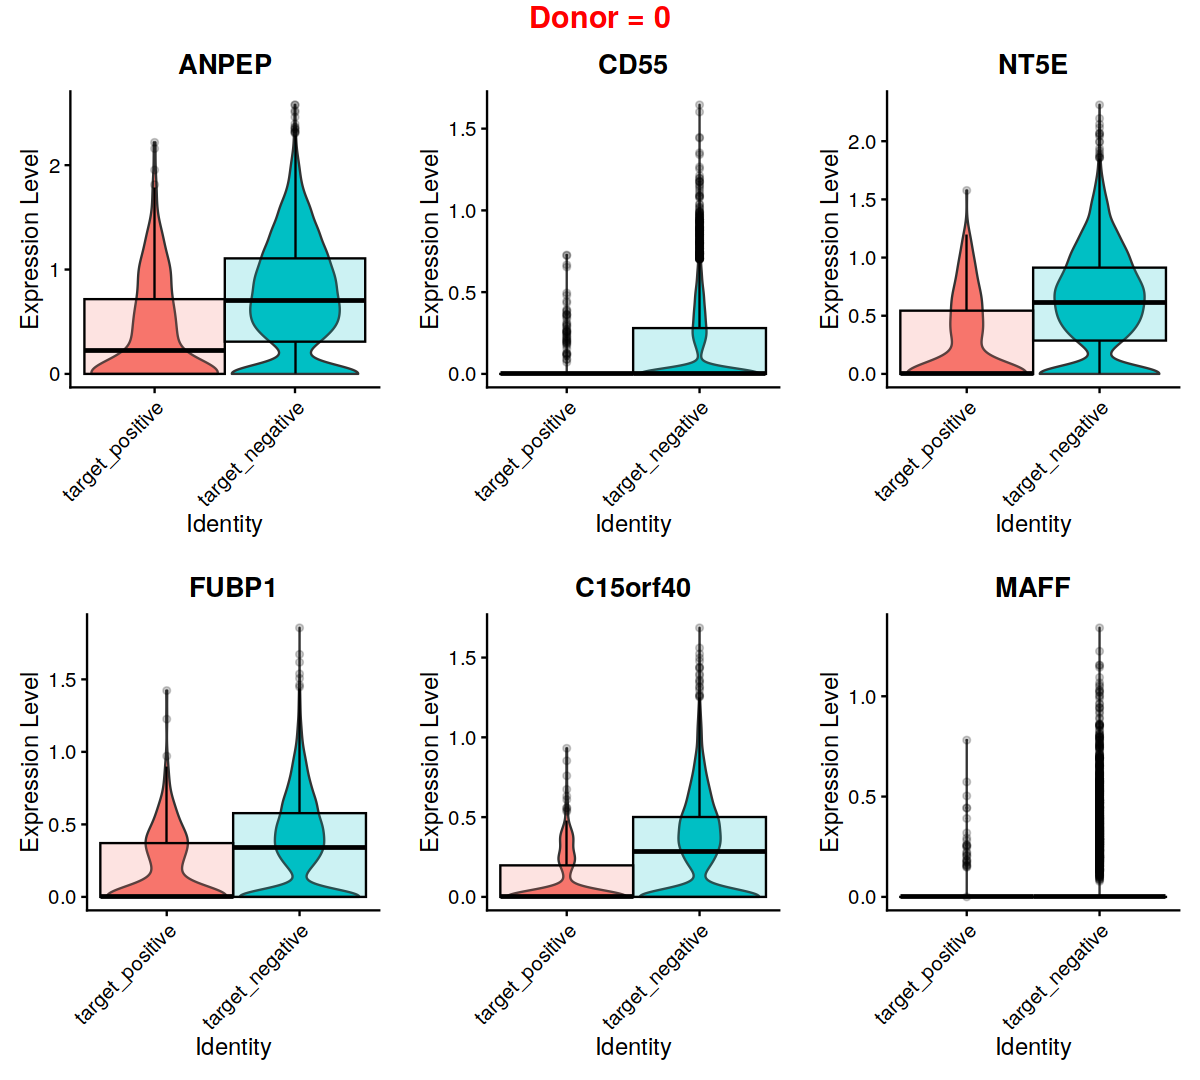

[1] "ANPEP"
Guide+ = 434 ; Guide- = 5803 
[1] "CD55"
Guide+ = 371 ; Guide- = 5866 
[1] "NT5E"
Guide+ = 346 ; Guide- = 5891 
[1] "FUBP1"
Guide+ = 331 ; Guide- = 5906 
[1] "C15orf40"
Guide+ = 393 ; Guide- = 5844 
[1] "MAFF"
Guide+ = 327 ; Guide- = 5910 


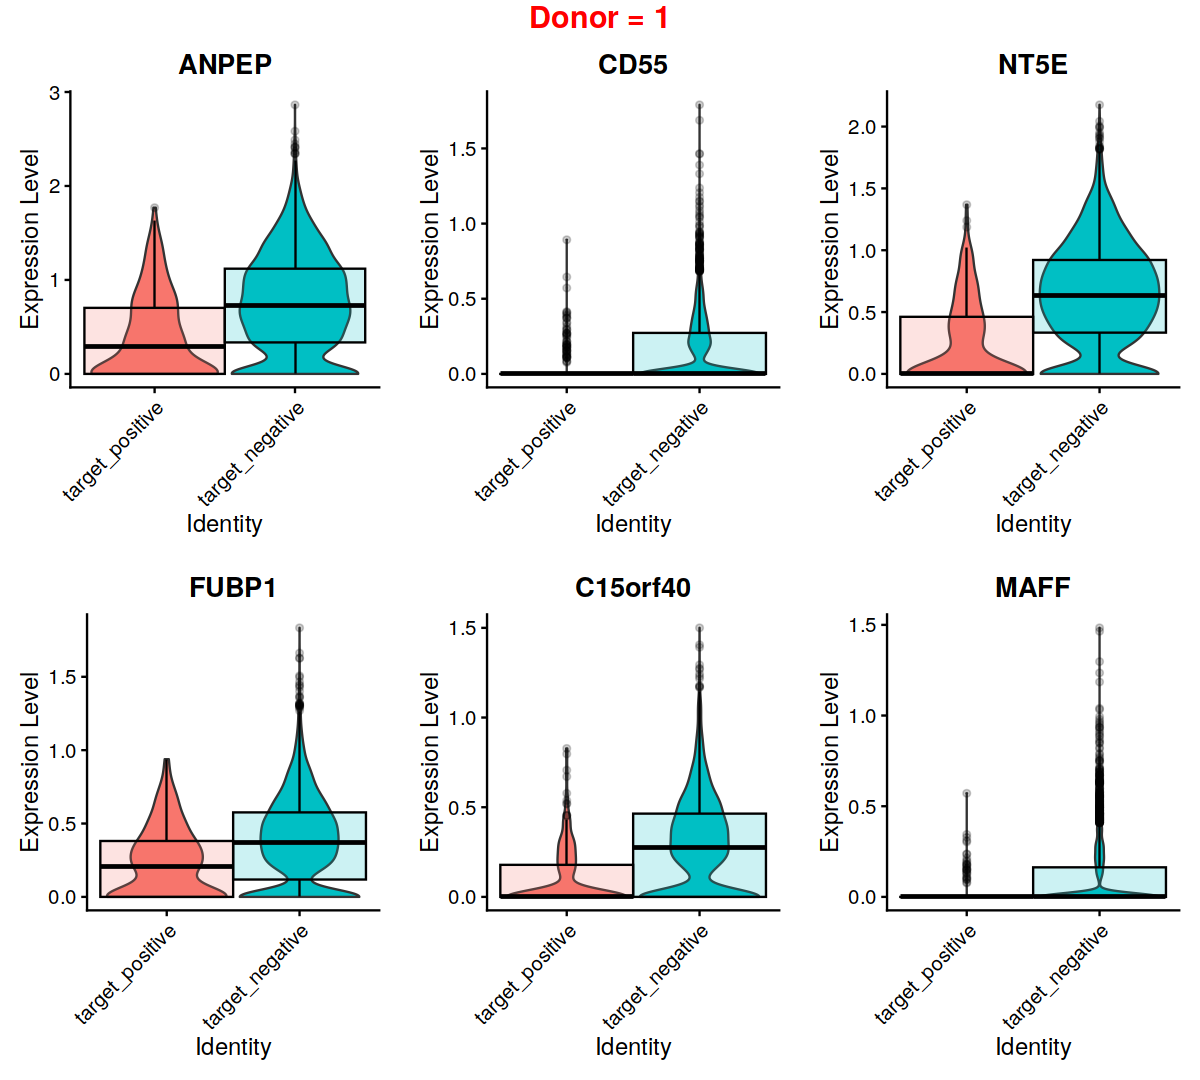

[1] "ANPEP"
Guide+ = 313 ; Guide- = 4526 
[1] "CD55"
Guide+ = 299 ; Guide- = 4540 
[1] "NT5E"
Guide+ = 284 ; Guide- = 4555 
[1] "FUBP1"
Guide+ = 233 ; Guide- = 4606 
[1] "C15orf40"
Guide+ = 289 ; Guide- = 4550 
[1] "MAFF"
Guide+ = 241 ; Guide- = 4598 


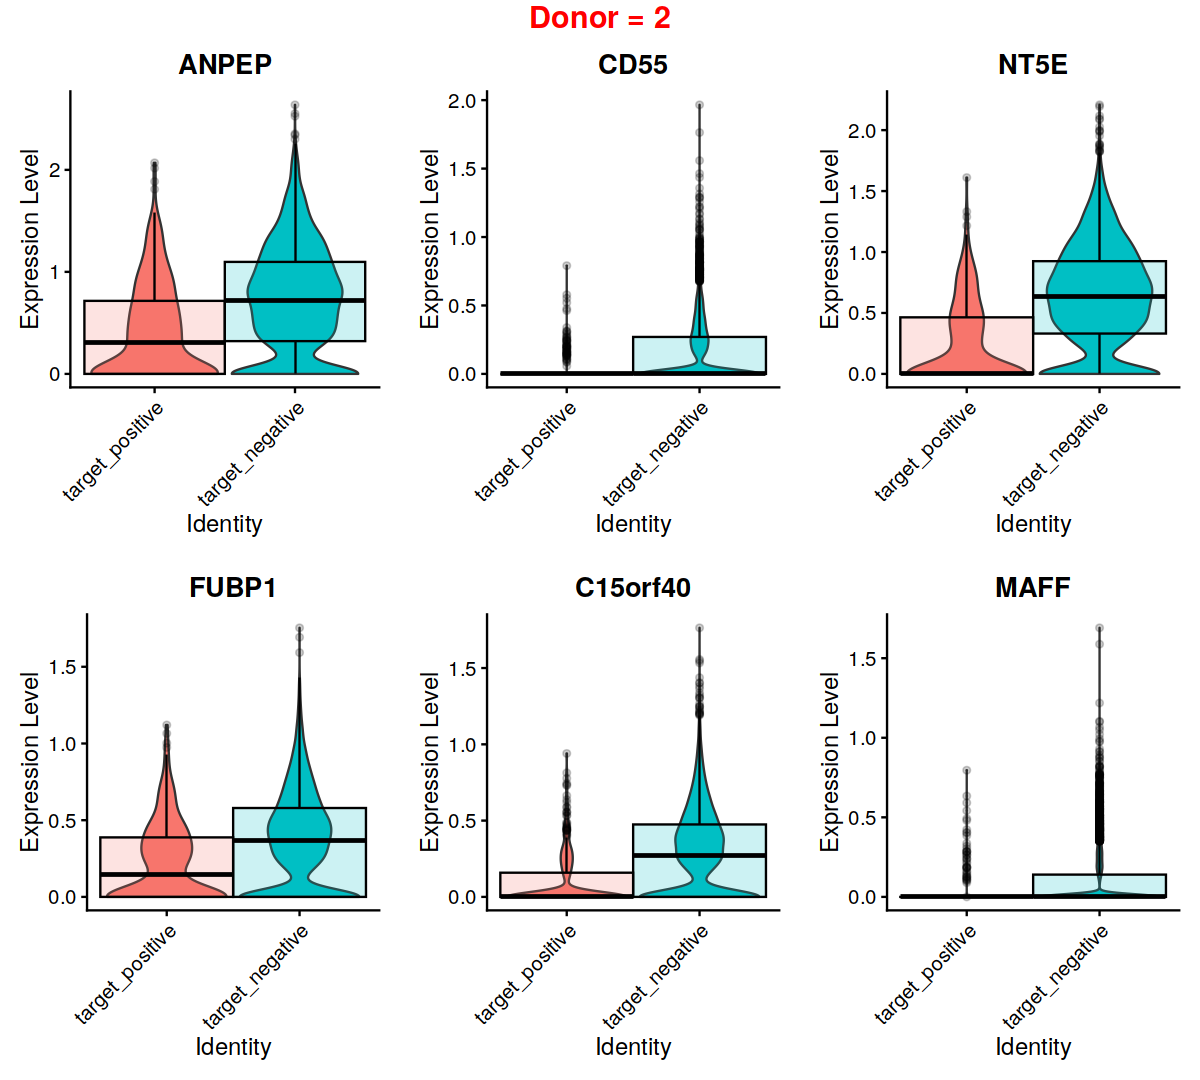

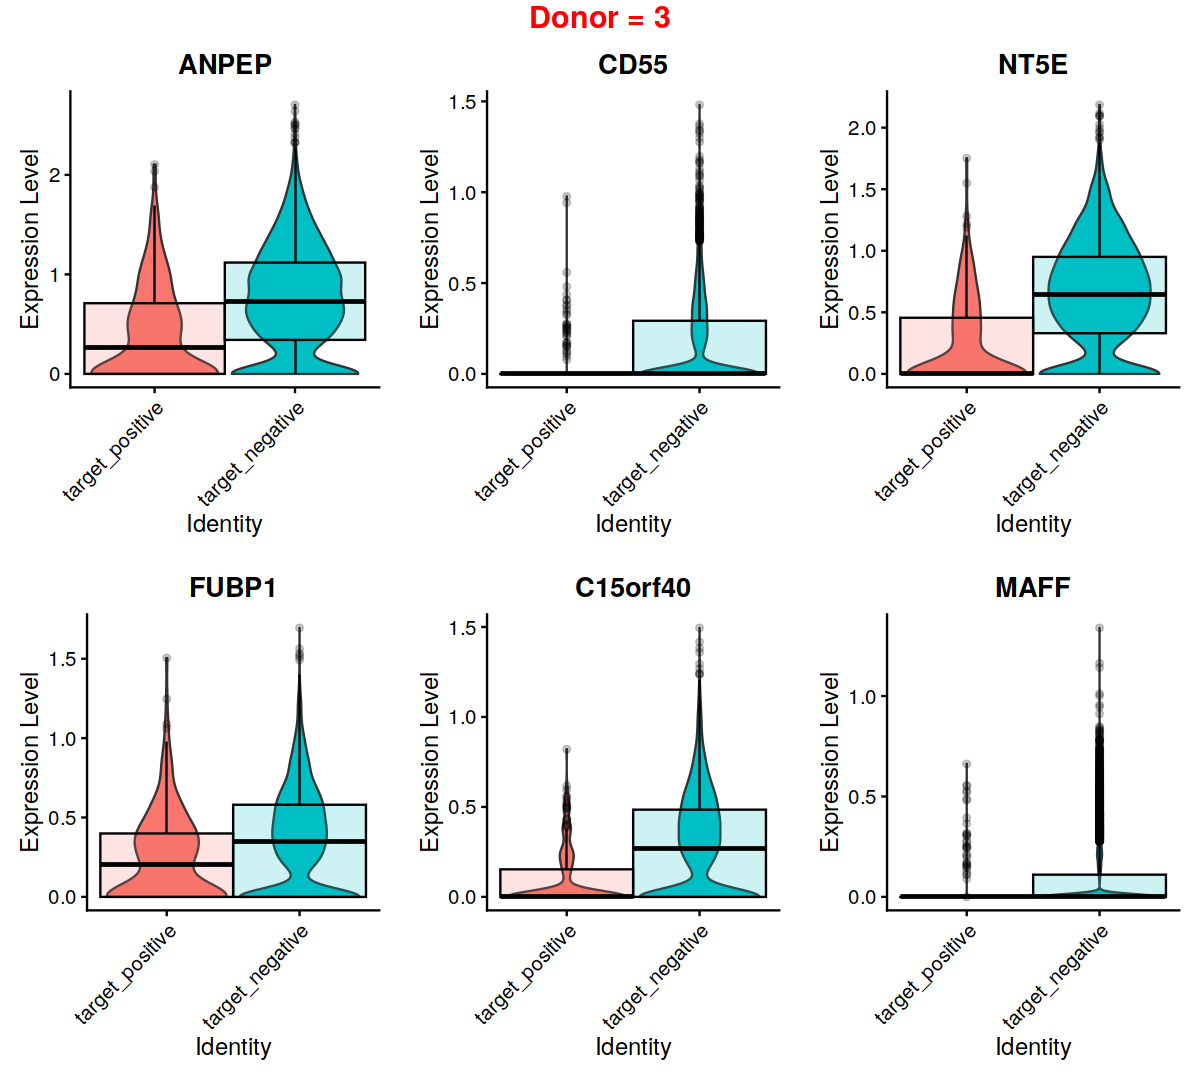

In [19]:
donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    targets = unique(filter(df_guide, subclass=='de_control')$alias)
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)

    targets = unique(filter(df_guide, subclass=='tss')$alias)
    plots = vlnplot_for_targets(seurat_donor, df_guide, perturbed_cells_by_guide, targets)
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width=10, repr.plot.height=9)
    p <- ggarrange(plotlist=plots, ncol=3, nrow = 2)
    p <- annotate_figure(p, top = text_grob(title, color = "red", face = "bold", size = 18))
    print(p)
}

## DE controls

[1] "FTH1"
Guide+ = 1004 ; Guide- = 4643 
[1] "PLIN3"
Guide+ = 629 ; Guide- = 5018 
[1] "TKT"
Guide+ = 589 ; Guide- = 5058 
[1] "LGALS3"
Guide+ = 628 ; Guide- = 5019 
[1] "CSTB"
Guide+ = 721 ; Guide- = 4926 
[1] "CTSB"
Guide+ = 665 ; Guide- = 4982 
[1] "KLF6"
Guide+ = 691 ; Guide- = 4956 
[1] "FTH1"
Guide+ = 865 ; Guide- = 3775 
[1] "PLIN3"
Guide+ = 544 ; Guide- = 4096 
[1] "TKT"
Guide+ = 488 ; Guide- = 4152 
[1] "LGALS3"
Guide+ = 522 ; Guide- = 4118 
[1] "CSTB"
Guide+ = 573 ; Guide- = 4067 
[1] "CTSB"
Guide+ = 558 ; Guide- = 4082 
[1] "KLF6"
Guide+ = 557 ; Guide- = 4083 


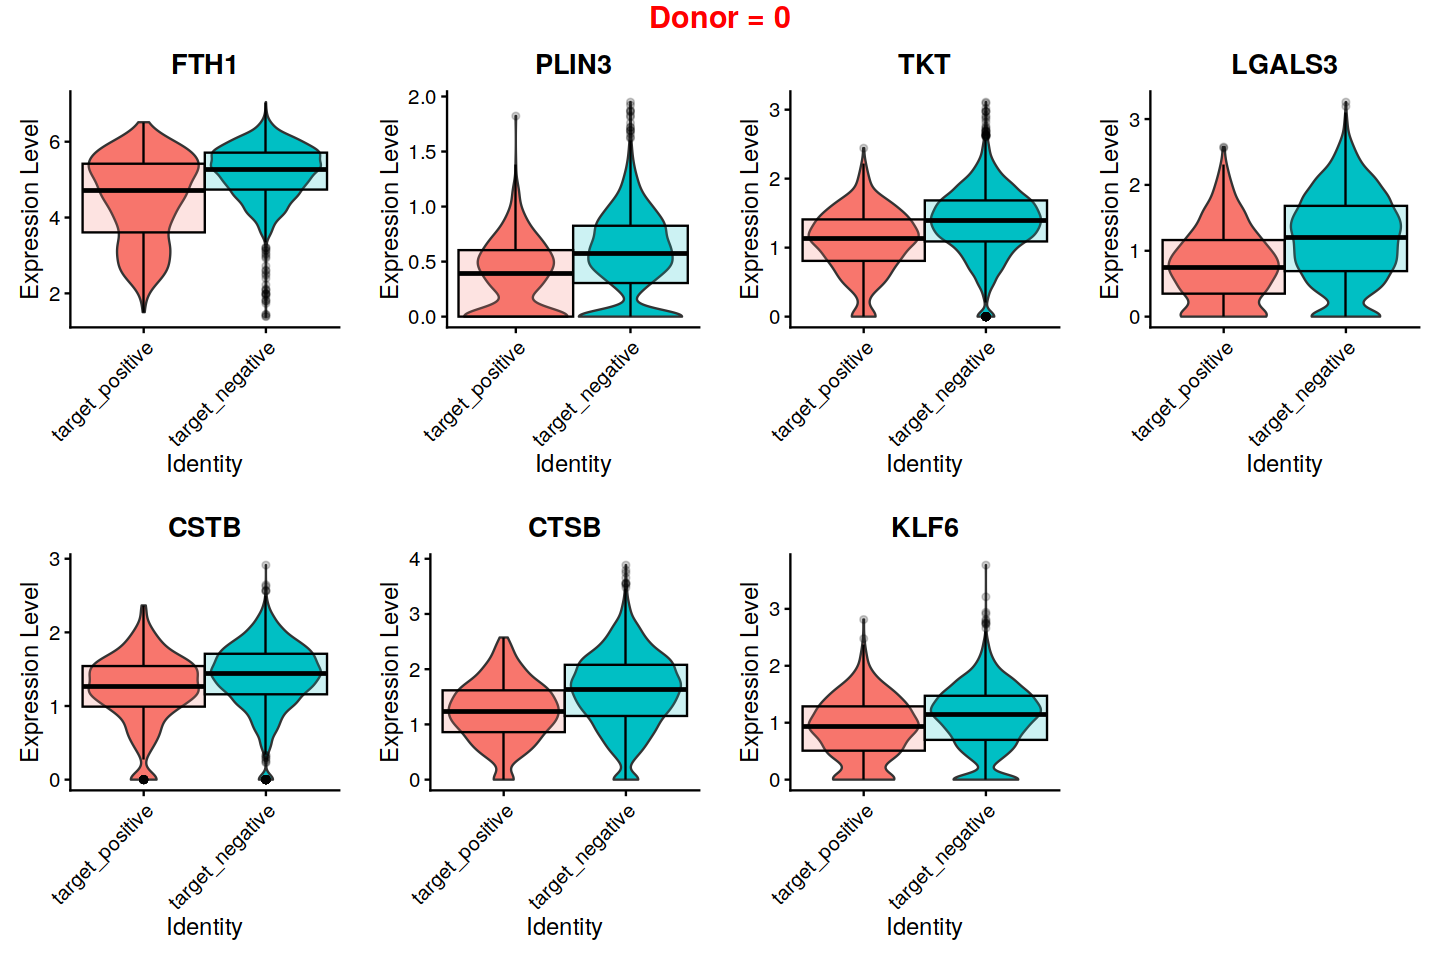

[1] "FTH1"
Guide+ = 1211 ; Guide- = 5026 
[1] "PLIN3"
Guide+ = 683 ; Guide- = 5554 
[1] "TKT"
Guide+ = 705 ; Guide- = 5532 
[1] "LGALS3"
Guide+ = 728 ; Guide- = 5509 
[1] "CSTB"
Guide+ = 772 ; Guide- = 5465 
[1] "CTSB"
Guide+ = 772 ; Guide- = 5465 
[1] "KLF6"
Guide+ = 739 ; Guide- = 5498 


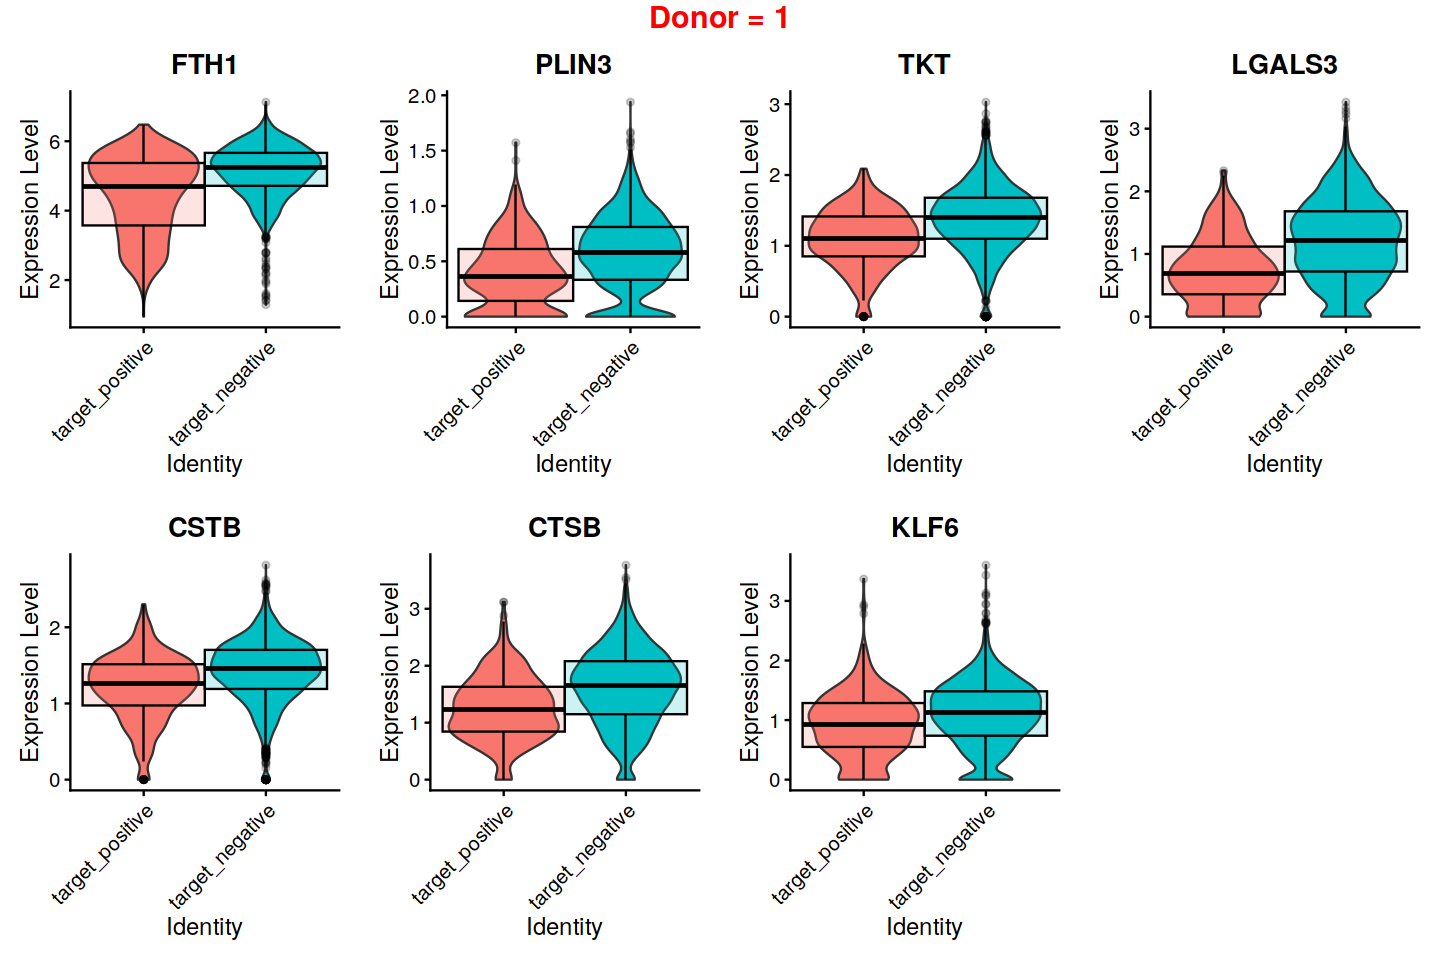

[1] "FTH1"
Guide+ = 917 ; Guide- = 3922 
[1] "PLIN3"
Guide+ = 501 ; Guide- = 4338 
[1] "TKT"
Guide+ = 473 ; Guide- = 4366 
[1] "LGALS3"
Guide+ = 573 ; Guide- = 4266 
[1] "CSTB"
Guide+ = 576 ; Guide- = 4263 
[1] "CTSB"
Guide+ = 587 ; Guide- = 4252 
[1] "KLF6"
Guide+ = 563 ; Guide- = 4276 


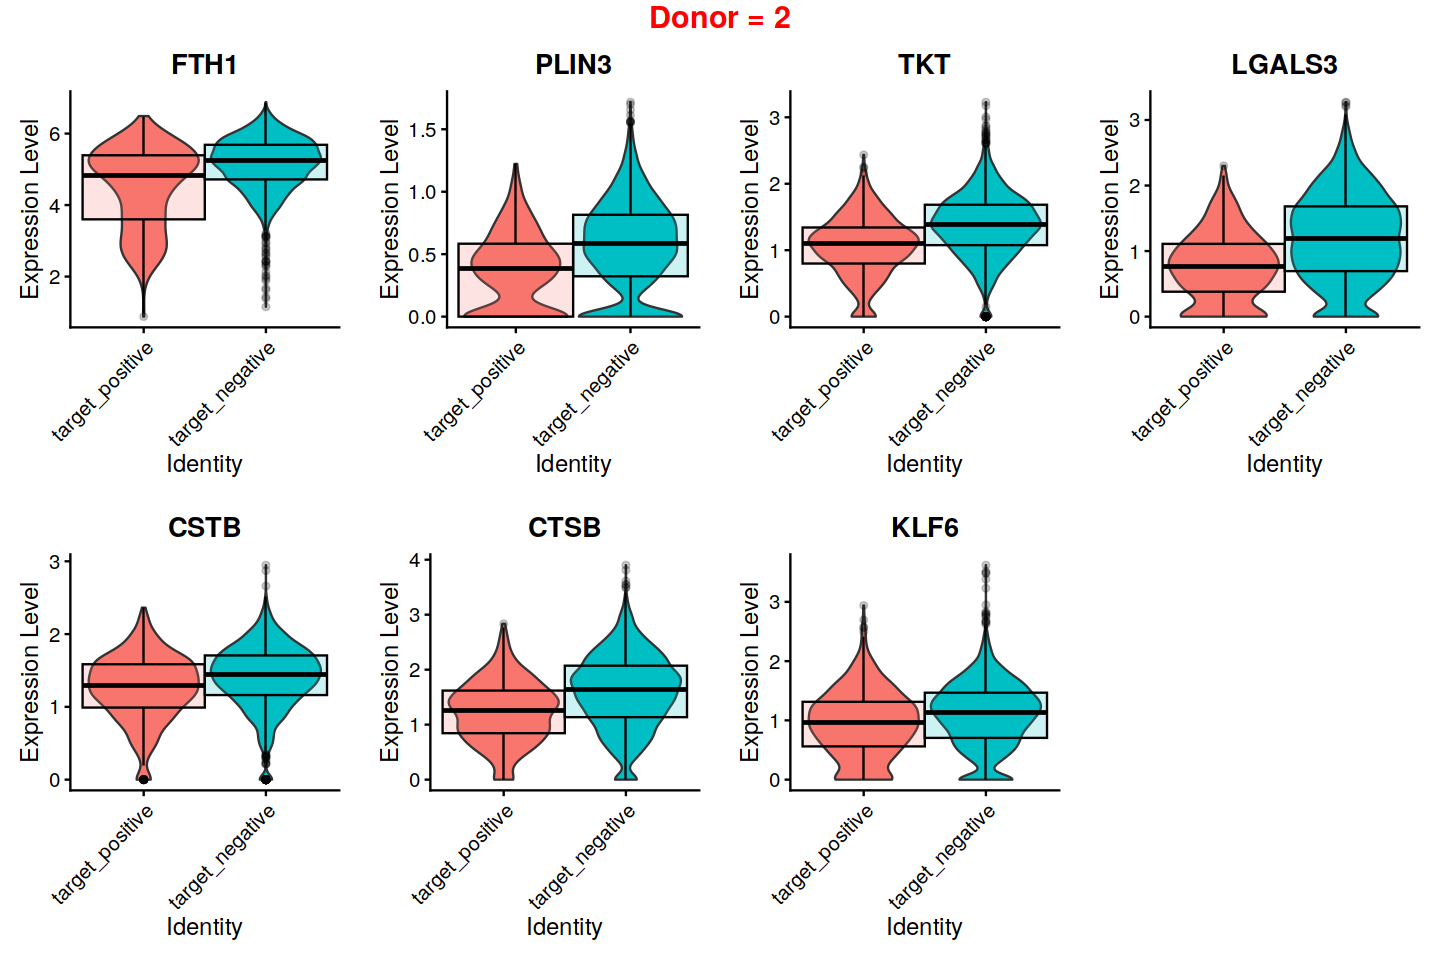

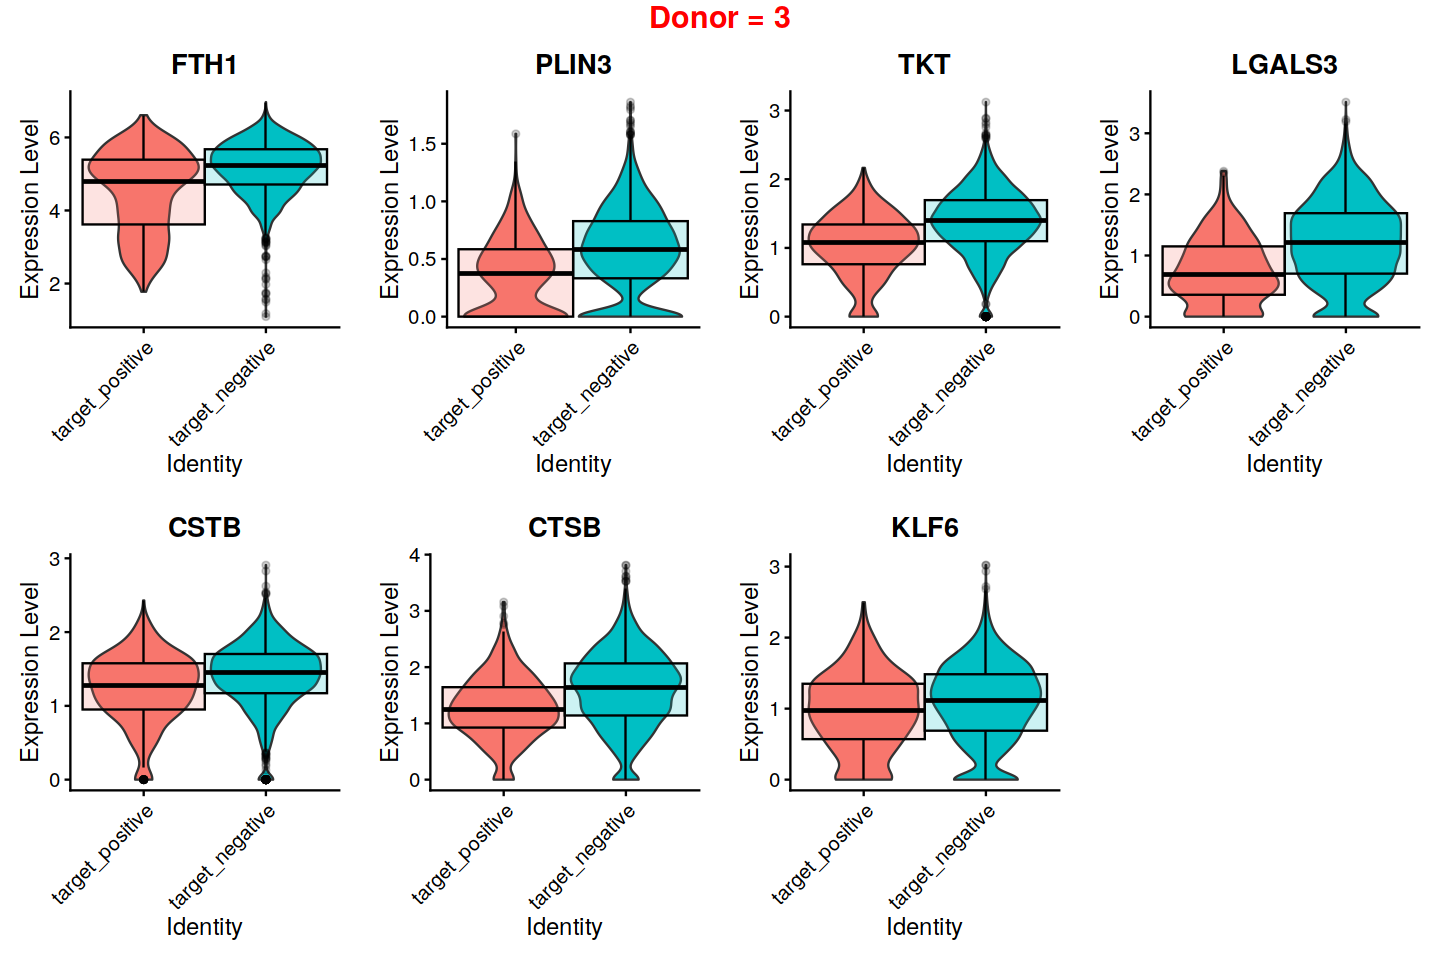

In [20]:
donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    targets = unique(filter(df_guide, subclass=='de_control')$alias)
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)
    
    plots = vlnplot_for_targets(seurat_donor, df_guide, perturbed_cells_by_guide, targets)
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width=12, repr.plot.height=8)
    p <- ggarrange(plotlist=plots, ncol=4, nrow = 2) 
    p <- annotate_figure(p, top = text_grob(title, color = "red", face = "bold", size = 18))  
    print(p)
}

## CKD DE 

Adding an extra gene or two the regulated_genes list to use as controls

[1] "DE6"
Guide+ = 886 ; Guide- = 4762 


Picking joint bandwidth of 0.08

Picking joint bandwidth of 0.0984

Picking joint bandwidth of 0.123



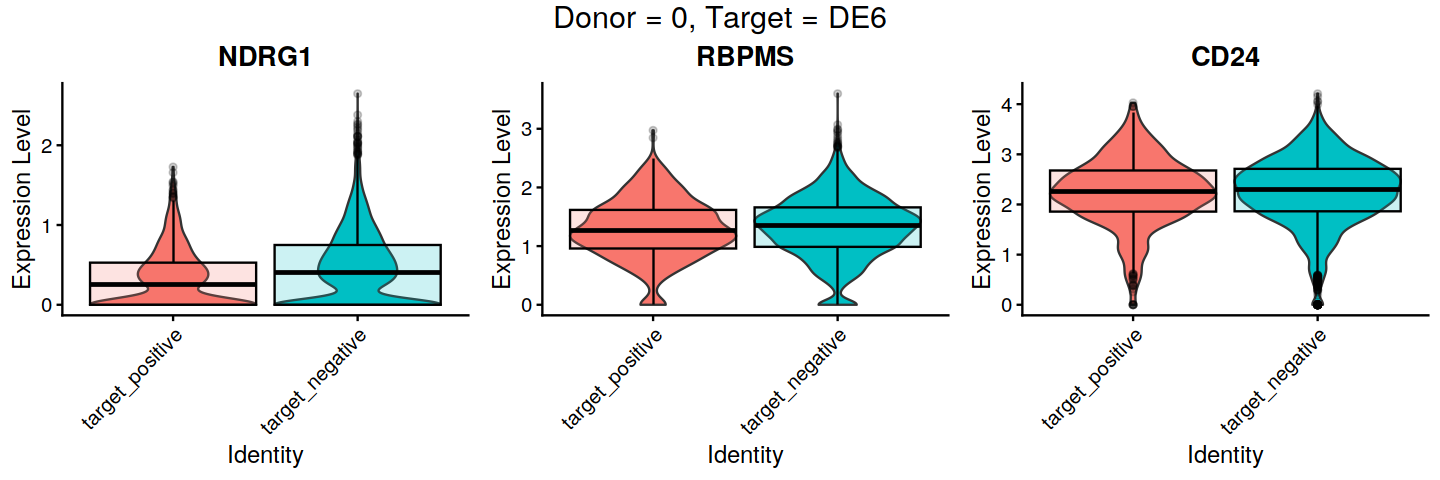

[1] "DE15"
Guide+ = 712 ; Guide- = 4935 


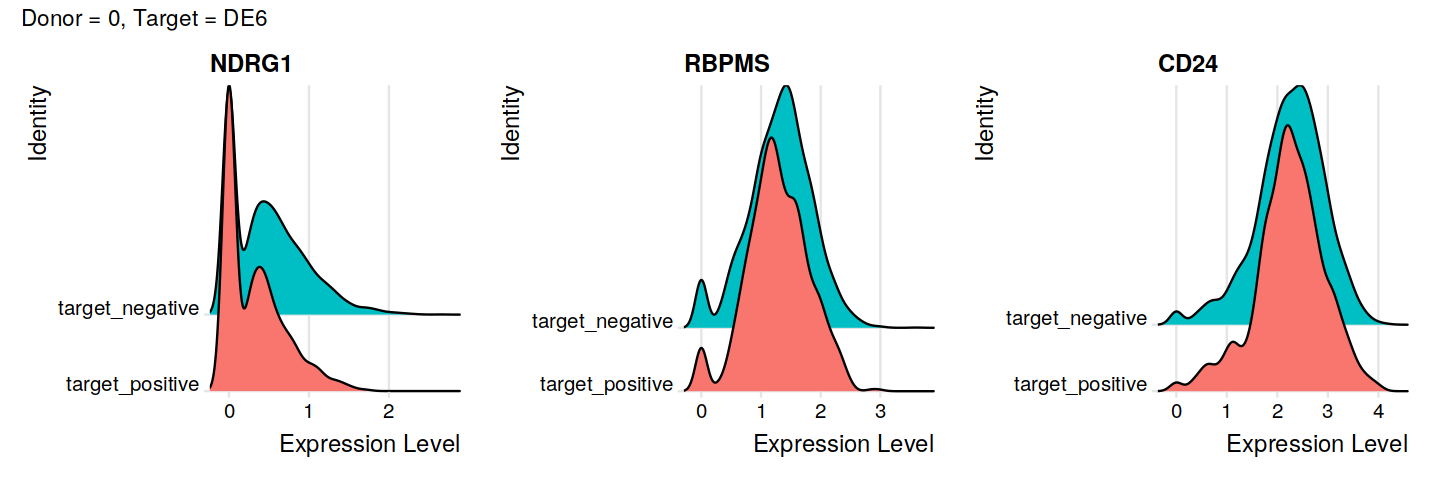

Picking joint bandwidth of 0.0889

Picking joint bandwidth of 0.101

Picking joint bandwidth of 0.128



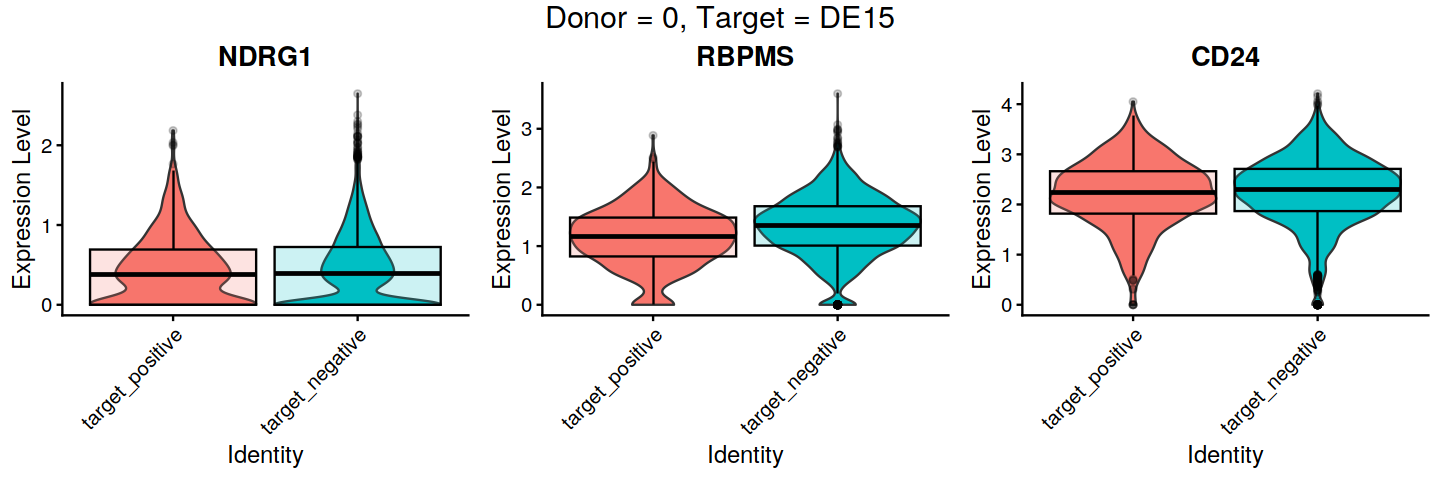

[1] "DE6"
Guide+ = 712 ; Guide- = 3929 


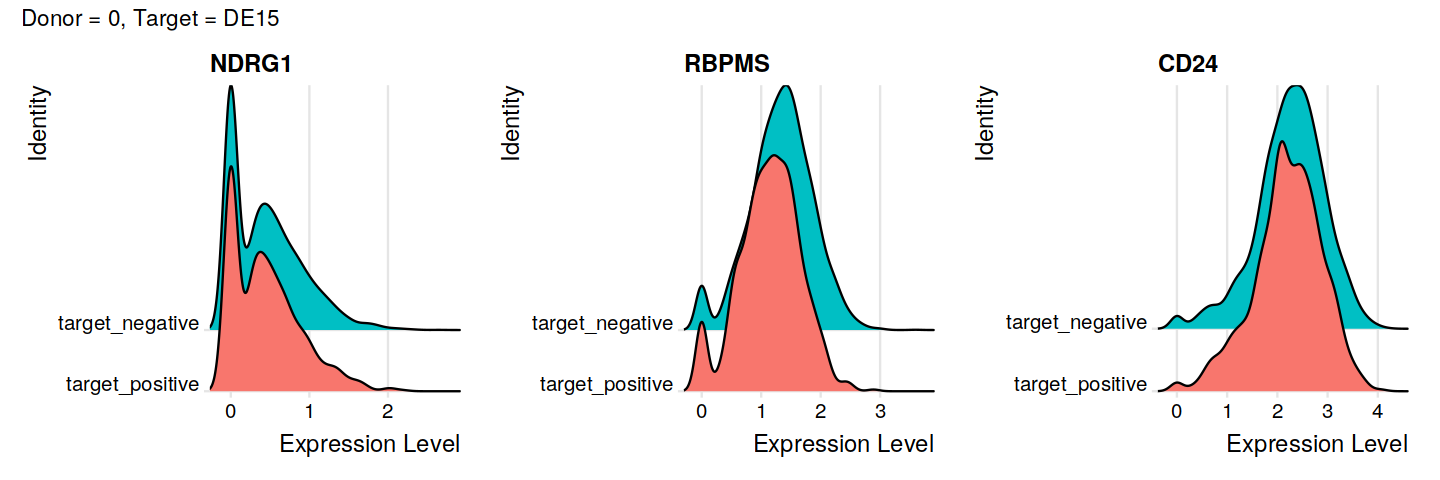

Picking joint bandwidth of 0.0778

Picking joint bandwidth of 0.0978

Picking joint bandwidth of 0.129



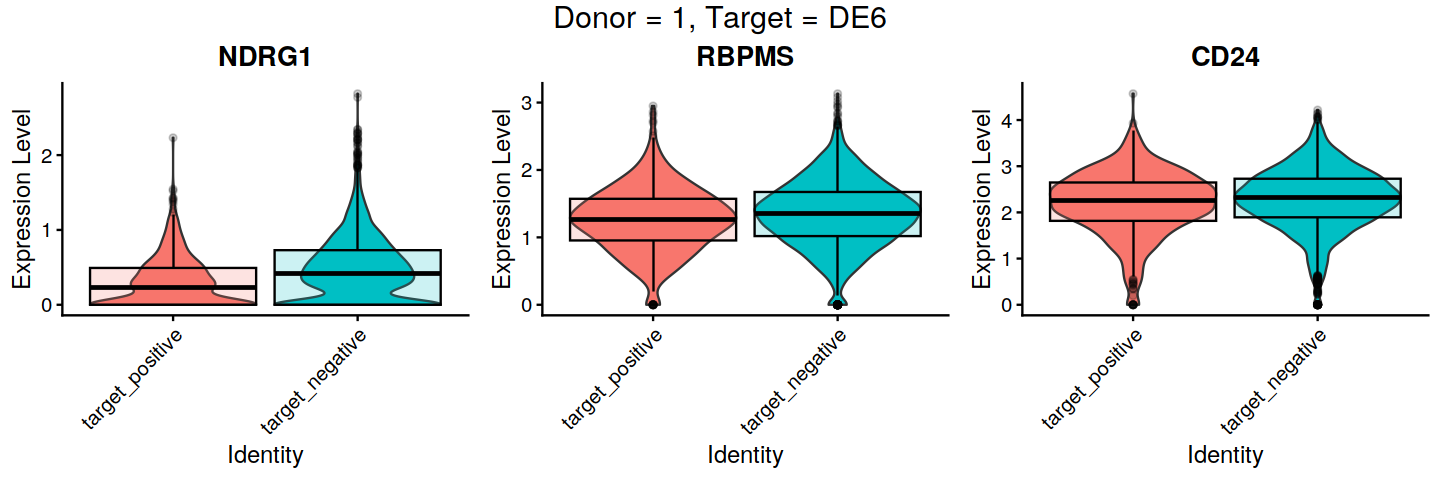

[1] "DE15"
Guide+ = 580 ; Guide- = 4060 


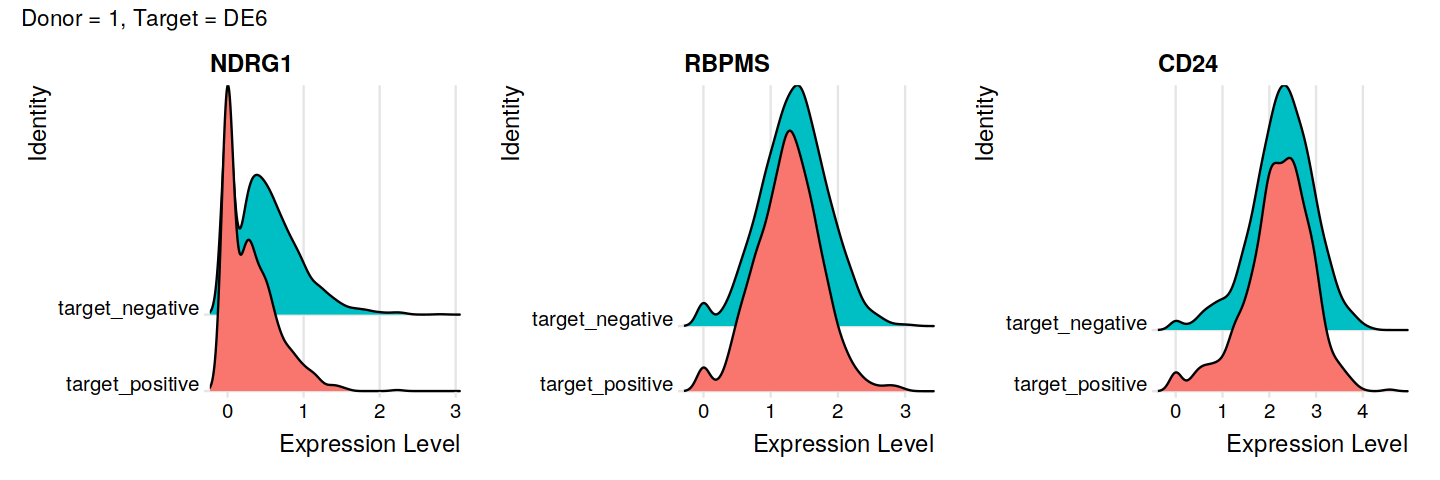

Picking joint bandwidth of 0.0871

Picking joint bandwidth of 0.0941

Picking joint bandwidth of 0.13



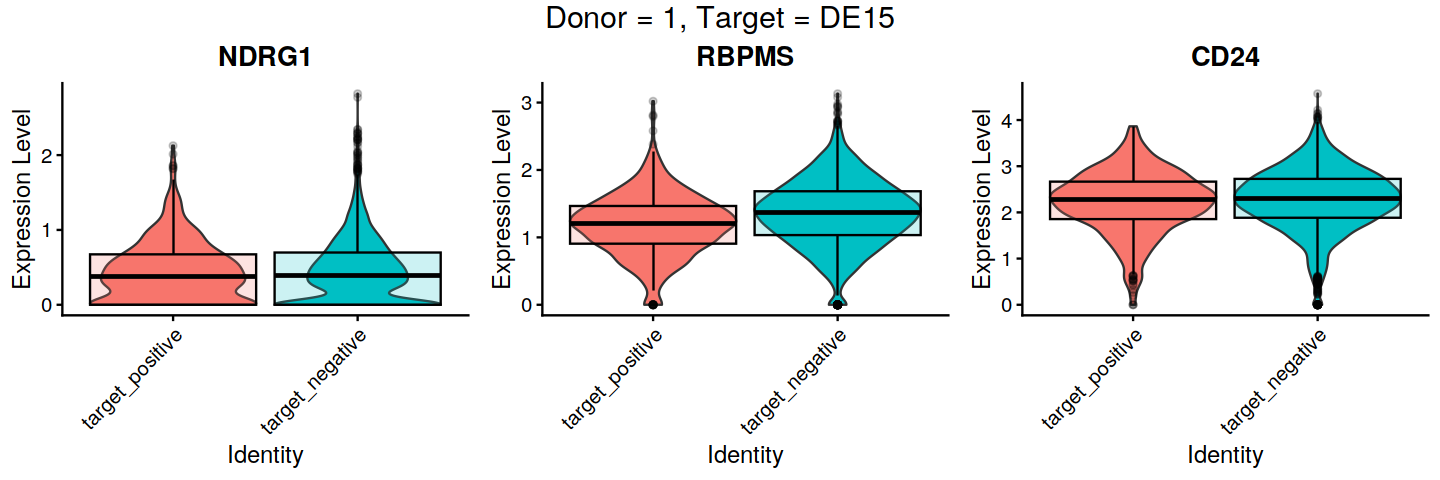

[1] "DE6"
Guide+ = 936 ; Guide- = 5302 


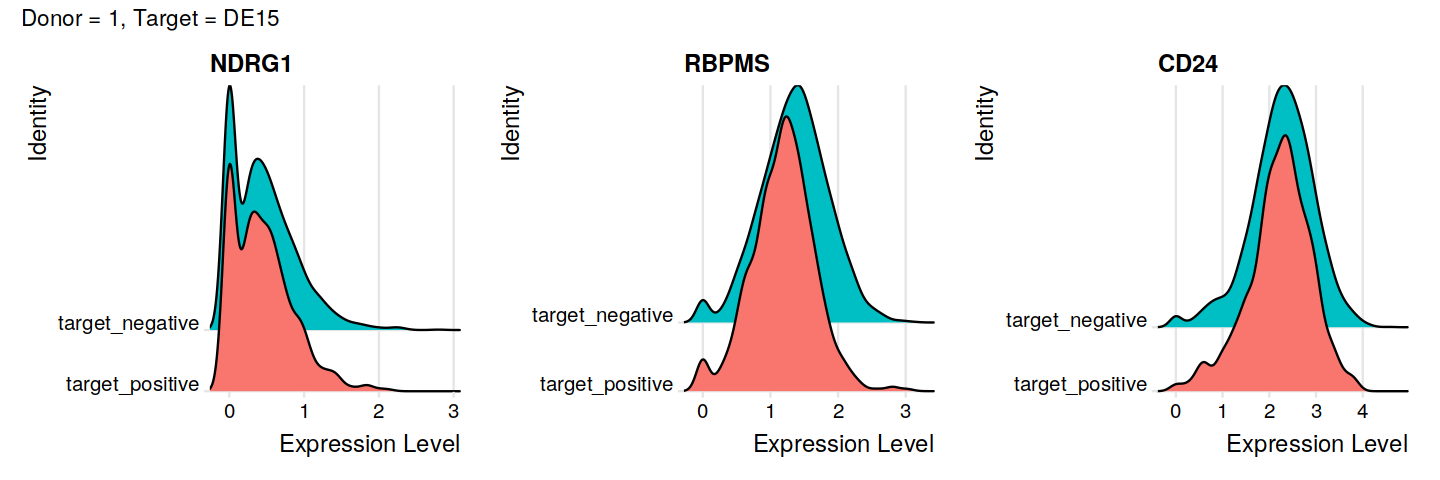

Picking joint bandwidth of 0.0739

Picking joint bandwidth of 0.0928

Picking joint bandwidth of 0.122



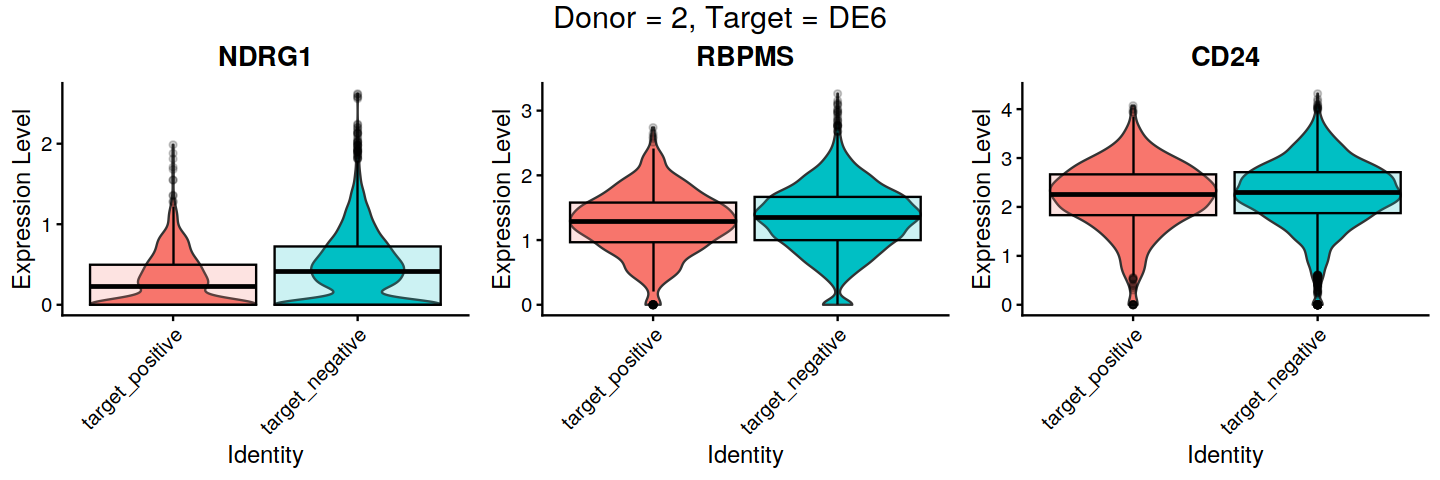

[1] "DE15"
Guide+ = 750 ; Guide- = 5487 


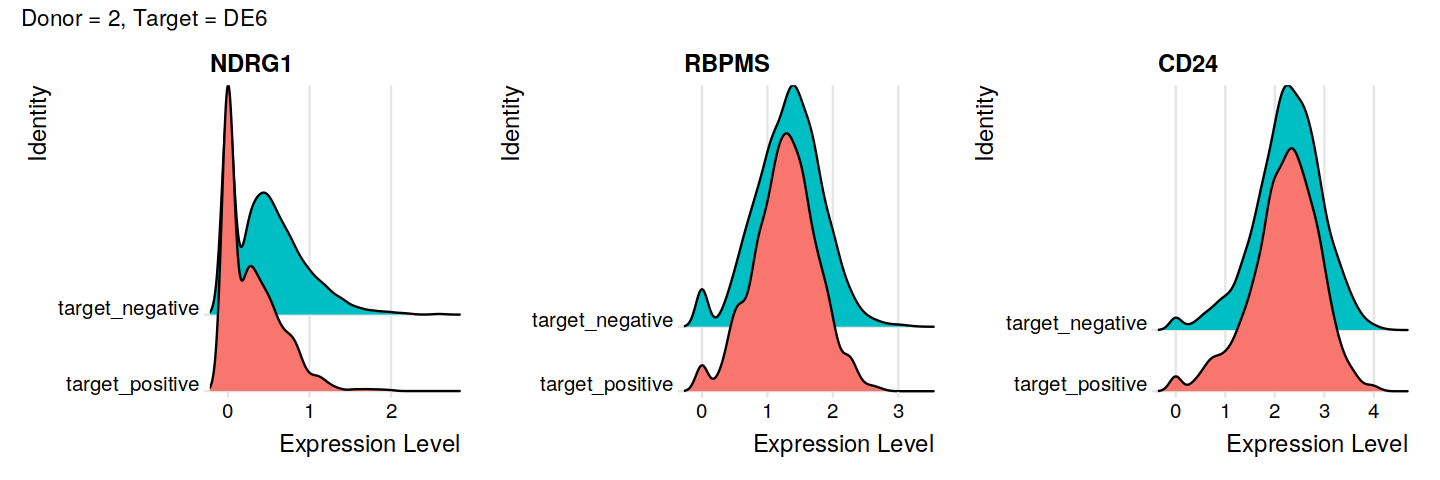

Picking joint bandwidth of 0.0835

Picking joint bandwidth of 0.0989

Picking joint bandwidth of 0.127



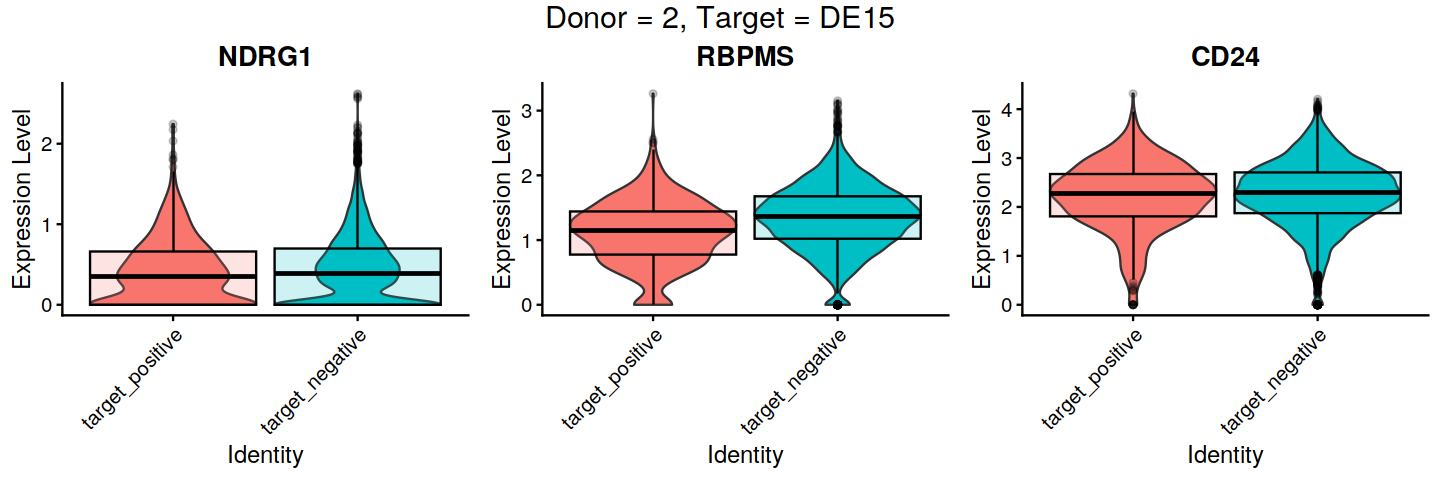

[1] "DE6"
Guide+ = 713 ; Guide- = 4127 


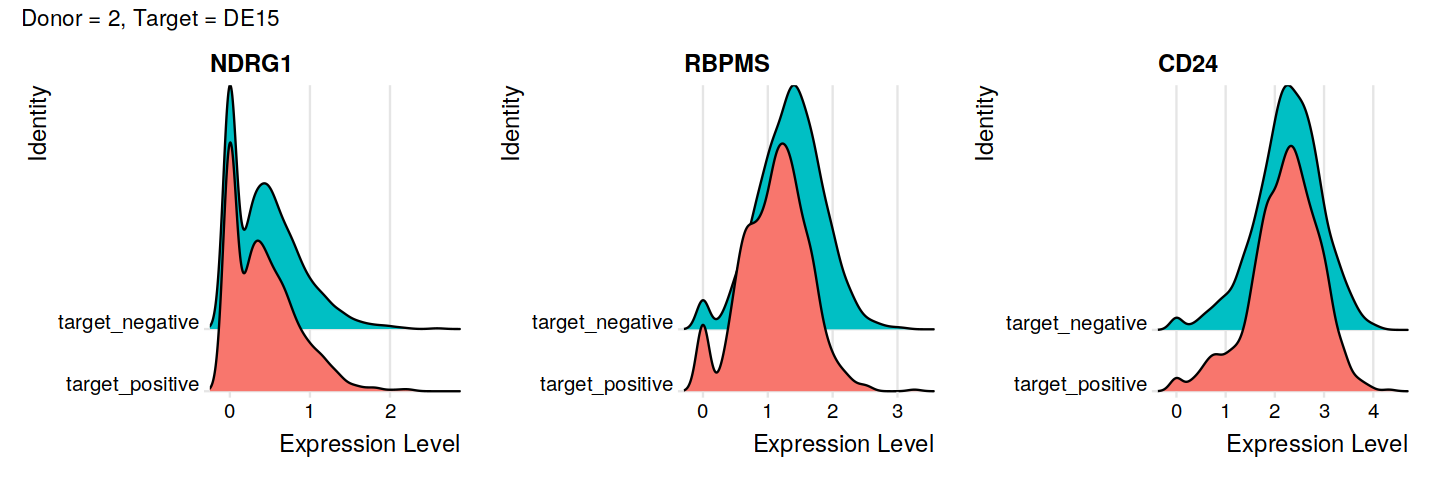

Picking joint bandwidth of 0.0766

Picking joint bandwidth of 0.103

Picking joint bandwidth of 0.128



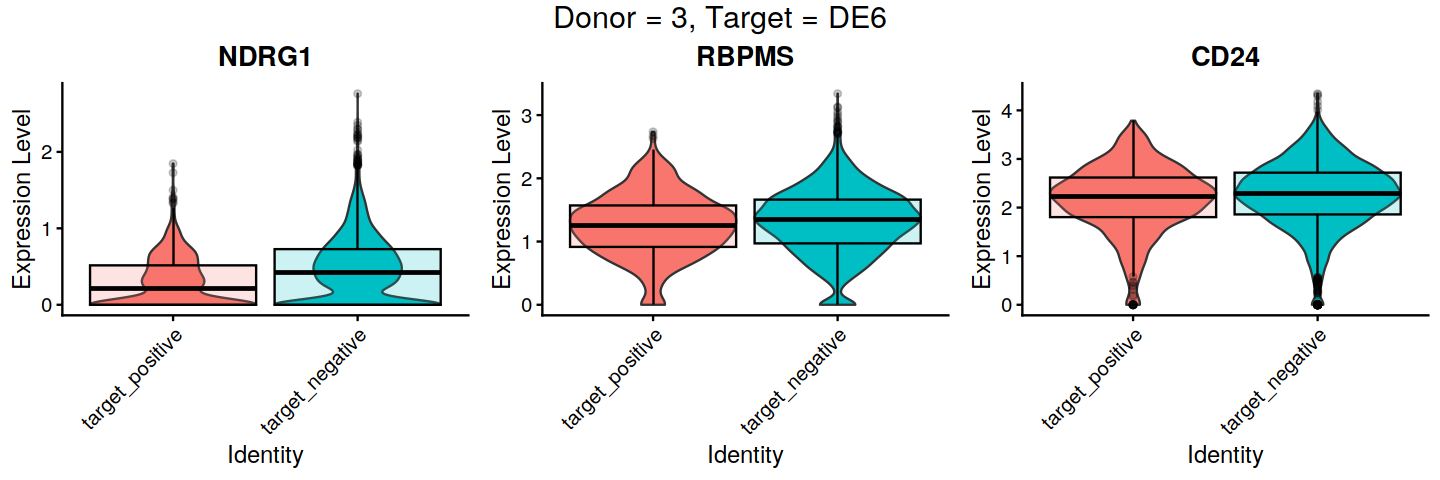

[1] "DE15"
Guide+ = 620 ; Guide- = 4219 


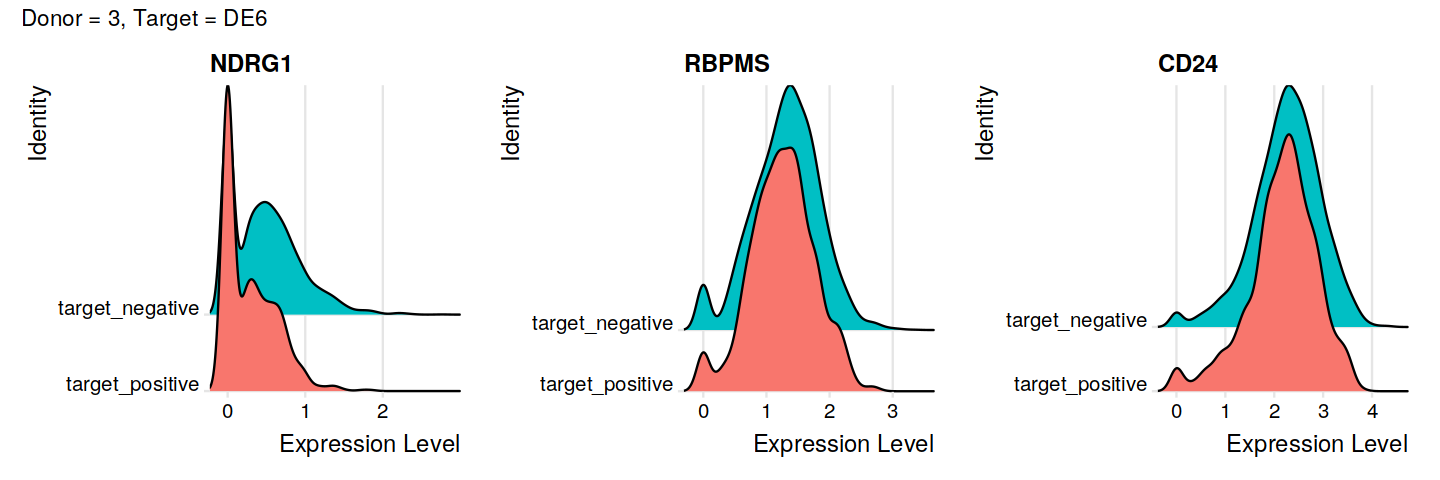

Picking joint bandwidth of 0.0886

Picking joint bandwidth of 0.102

Picking joint bandwidth of 0.136



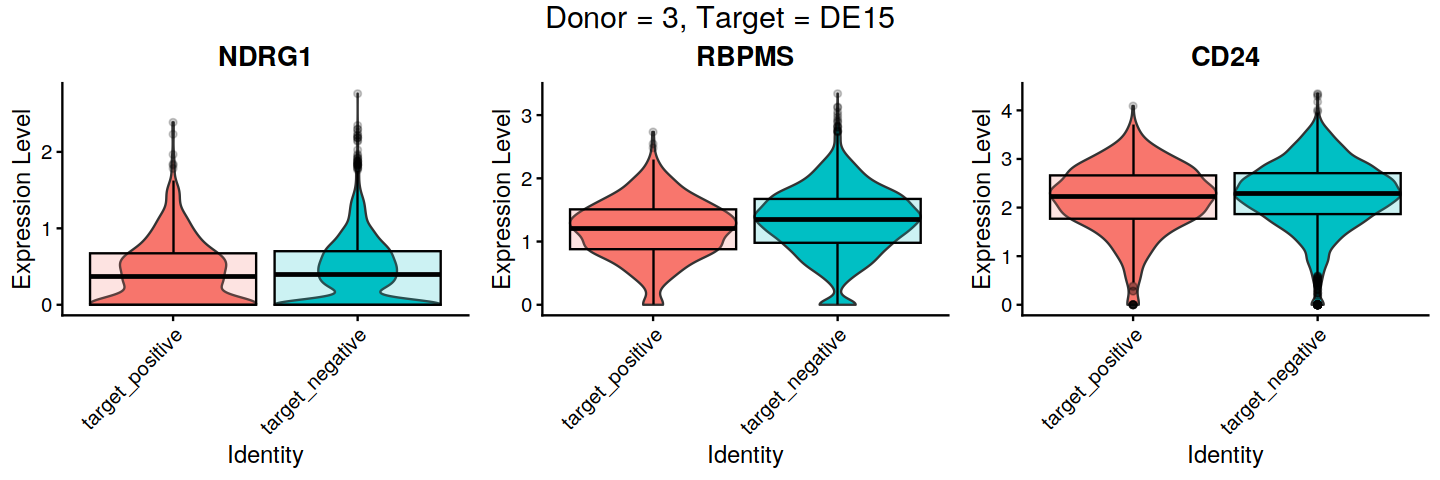

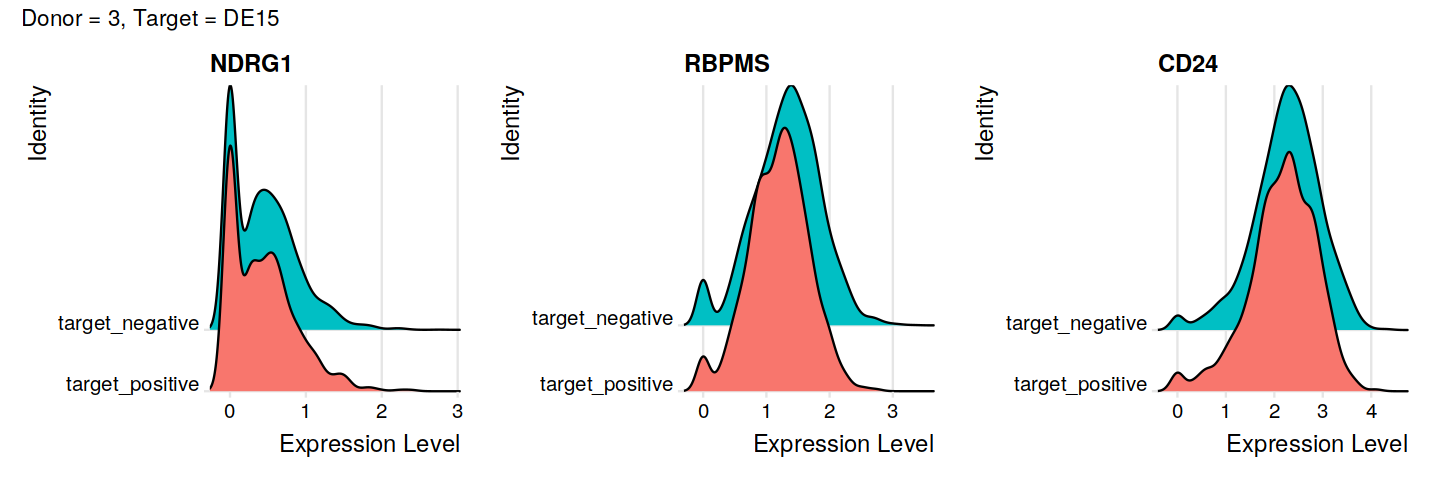

In [21]:
targets = c("DE6", "DE15")
regulated_genes = c("NDRG1", "RBPMS", "CD24")

donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, donor_id)    

    for(i in seq_along(targets)) {        
        target = targets[i]
        title <- paste0("Donor = ", donor_id, ", Target = ", target)
        print(target)
        guides = get_guides_by_subclass(df_guide, 'alias', target)
        seurat_donor <- mark_target_pos_neg(
            seurat_donor, 
            perturbed_cells_by_guide, 
            guides, 
            print_counts = T
        ) 

        options(repr.plot.width=6, repr.plot.height=4)
        plots <- VlnPlot(
                object = seurat_donor,
                features = regulated_genes, 
                idents = NULL, 
                pt.size = 0, 
                sort = F, 
                ncol = 3,  
                combine = F  
            ) 

        for(i in 1:length(plots)) {
            plots[[i]] <- plots[[i]] + 
            NoLegend() +
            geom_boxplot(width=2, color="black", alpha=0.2)
        }
        plt1 <- ggarrange(plotlist=plots, ncol=3, nrow = 1) 
        plt1 <- annotate_figure(plt1, top = text_grob(title, color = "black", size = 18))  

        options(repr.plot.width=12, repr.plot.height=4)
        plt2 <- RidgePlot(
            object = seurat_donor,
            features = regulated_genes, 
            idents = NULL,  
            sort = F, 
            ncol = 3,    
        ) + plot_annotation(title = title)

        print(plt1) 
        print(plt2)
    }

}

In [22]:
print(df_de %>% filter(donor == donor_id) %>% arrange(p_val_adj) )

        p_val avg_log2FC pct.1 pct.2 p_val_adj      de_gene   target donor
1    4.2e-103      -0.53 1.000 1.000   1.5e-98         FTH1     FTH1     3
2     7.8e-54      -0.62 0.423 0.813   2.8e-49         NT5E     NT5E     3
3     2.3e-53      -0.75 0.846 0.916   8.4e-49       LGALS3   LGALS3     3
4     1.1e-47      -0.51 0.937 0.981   4.2e-43          TKT      TKT     3
5     8.4e-38      -0.32 0.287 0.612   3.1e-33     C15orf40 C15orf40     3
6     9.4e-33      -0.32 0.687 0.817   3.5e-28        PLIN3    PLIN3     3
7     1.3e-30      -0.53 0.957 0.960   4.6e-26         CTSB     CTSB     3
8     3.7e-28      -0.51 0.556 0.802   1.3e-23        ANPEP    ANPEP     3
9     2.5e-27      -0.33 0.553 0.702   9.3e-23        NDRG1      DE6     3
10    9.6e-24      -0.20 0.130 0.394   3.5e-19         CD55     CD55     3
11    3.7e-20      -0.24 0.962 0.978   1.3e-15         CSTB     CSTB     3
12    1.4e-17       0.19 0.930 0.886   5.3e-13       SNHG16     FTH1     3
13    9.0e-15       0.26 